# Sentinel-3 Analysis Notebook

In [1]:
!jupyter nbextension enable toc

import netCDF4 as nc
from os import listdir
import re
import numpy as np
import geopandas as gpd
import pandas as pd
import xarray as xr
from matplotlib.pyplot import figure
from scipy import spatial
from numpy import ravel
import datetime
import re
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import os
from itertools import compress
from scipy.stats import pearsonr


from sklearn.ensemble import RandomForestRegressor
from numpy import mean
from numpy import std
from numpy import arange
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from boruta import BorutaPy
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline


pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

Enabling notebook extension toc...
      - Validating: OK


# Get Shapefiles and Spatial Data

In [2]:
import sys, os

root = "/Volumes/Data Drive/RemoteSensing/s3_processed"
path = os.path.join(root, "s3_processed")

filenames = []
for path, subdirs, files in os.walk(root):
    for name in files:
        filenames.append(os.path.join(path, name))

In [3]:
df3 = pd.read_csv("/Users/maxbeal/Desktop/PhD/Sampling/Mendota_data/Final Data/Mendota_all_data.csv")


def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]


# Get shapefiles
mendota = gpd.read_file("/Users/maxbeal/Desktop/PhD/Sampling/Mendota Shapefiles/Mendotaboundary.shp")
print(mendota.crs)
mendota = mendota.to_crs("EPSG:4326")


# Save mendota 4326
mendota = mendota.to_crs("EPSG:4326")
mendota.to_file("/Users/maxbeal/Desktop/PhD/Sampling/Mendota Shapefiles/Mendotaboundary4326.shp", driver='ESRI Shapefile')

gridshp = gpd.read_file("/Users/maxbeal/Desktop/PhD/Sampling/Mendota Shapefiles/Mendotaboundary_gridnums.shp")
gridshp = gridshp.to_crs("EPSG:4326")


df = pd.read_csv('/Users/maxbeal/Desktop/PhD/Sampling/Mendota_data/Final Data/mendota_reference_all.csv')
crs = mendota.crs
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=gpd.points_from_xy(df.long, df.lat))


gdf = gdf[gdf['Notes']!="shoreline"] #Remove shoreline points



bl = []
for i in filenames:
    bl.append(i.endswith("L2W.nc"))
    
l2w=list(compress(filenames,bl))


img_dates=[]
for i in l2w:
    img_date=str(datetime.date(int(i[65:69:1]),int(i[70:72:1]),int(i[73:75:1]))) 
    img_dates.append(img_date)

gdfDates = gdf['Date']


gdfDates=np.array(gdfDates)
bl2 = []
for i in img_dates:
    bl2.append(i in gdfDates)

datelist=list(compress(img_dates,bl2))

img_dates


epsg:3071


['2018-05-02',
 '2018-05-04',
 '2018-05-06',
 '2018-05-07',
 '2018-05-08',
 '2018-05-10',
 '2018-05-11',
 '2018-05-14',
 '2018-05-18',
 '2018-05-19',
 '2018-05-22',
 '2018-05-23',
 '2018-05-26',
 '2018-05-29',
 '2018-05-31',
 '2018-06-02',
 '2018-06-03',
 '2018-06-04',
 '2018-06-06',
 '2018-06-07',
 '2018-06-10',
 '2018-06-14',
 '2018-06-15',
 '2018-06-18',
 '2018-06-19',
 '2018-06-22',
 '2018-06-25',
 '2018-06-27',
 '2018-06-29',
 '2018-06-30',
 '2018-07-01',
 '2018-07-03',
 '2018-07-04',
 '2018-07-07',
 '2018-07-12',
 '2018-07-15',
 '2018-07-16',
 '2018-07-19',
 '2018-07-22',
 '2018-07-24',
 '2018-07-26',
 '2018-07-27',
 '2018-07-28',
 '2018-07-30',
 '2018-07-31',
 '2018-08-03',
 '2019-05-05',
 '2019-05-08',
 '2019-05-09',
 '2019-05-12',
 '2019-05-15',
 '2019-05-17',
 '2019-05-19',
 '2019-05-20',
 '2019-05-21',
 '2019-05-23',
 '2019-05-24',
 '2019-05-27',
 '2019-05-31',
 '2019-06-01',
 '2019-06-04',
 '2019-06-05',
 '2019-06-08',
 '2019-06-11',
 '2019-06-13',
 '2019-06-15',
 '2019-06-

## Convert RFUs to ug/L

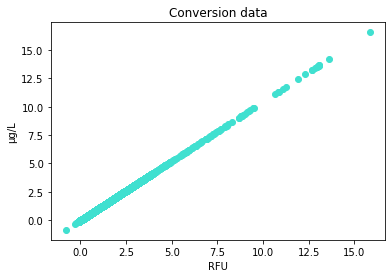

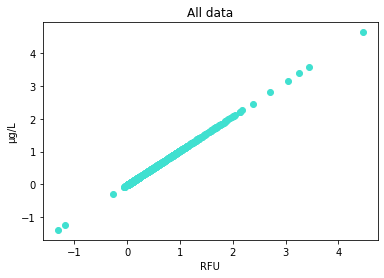

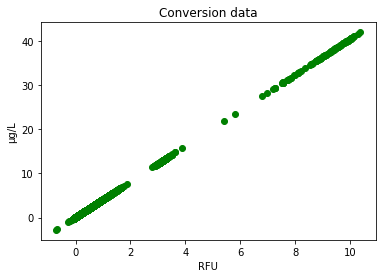

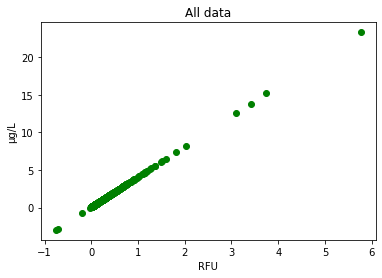

In [4]:
from sklearn import linear_model
df2 =  pd.read_csv("/Users/maxbeal/Desktop/PhD/Sampling/Mendota_data/Final Data/Mendota_all_data.csv")
conv = pd.read_csv('/Users/maxbeal/Desktop/PhD/Sampling/Sampling Data/RFU_ugL_2019.csv') #RFU to ugL, note conversion data isn't averaged
df2 = df2.dropna(subset=['BGA.PC.RFU','Chlorophyll.RFU'])
#Phycocyanin
plt.title('Conversion data')
plt.scatter(conv['BGA-PC RFU'],conv['BGA-PC µg/L'],facecolor="turquoise")
plt.xlabel('RFU')
plt.ylabel('µg/L')
plt.show()

#Create Regression
X=conv['BGA-PC RFU'].values.reshape(-1,1)
Y=conv['BGA-PC µg/L'].values.reshape(-1,1)

pc_lm = linear_model.LinearRegression()
pc_lm.fit(X,Y)

df2['BGA.PC.µgL']=pc_lm.predict(df2['BGA.PC.RFU'].values.reshape(-1,1))

plt.title('All data')
plt.scatter(df2['BGA.PC.RFU'],df2['BGA.PC.µgL'],facecolor="turquoise")
plt.xlabel('RFU')
plt.ylabel('µg/L')
plt.show()

#Chlorophyll-a
plt.title('Conversion data')
plt.scatter(conv['Chlorophyll RFU'],conv['Chlorophyll µg/L'],facecolor="g")
plt.xlabel('RFU')
plt.ylabel('µg/L')
plt.show()

#Create Regression
X=conv['Chlorophyll RFU'].values.reshape(-1,1)
Y=conv['Chlorophyll µg/L'].values.reshape(-1,1)

chl_lm = linear_model.LinearRegression()
chl_lm.fit(X,Y)

df2['Chlorophyll.µgL']=chl_lm.predict(df2['Chlorophyll.RFU'].values.reshape(-1,1))

plt.title('All data')
plt.scatter(df2['Chlorophyll.RFU'],df2['Chlorophyll.µgL'],facecolor="g")
plt.xlabel('RFU')
plt.ylabel('µg/L')
plt.show()


set(df2['Date'])

df2=df2[(df2['Chlorophyll.µgL']>=0) & (df2['BGA.PC.µgL']>=0)]

## Extract image data

In [5]:
import warnings
warnings.filterwarnings('ignore')

output = pd.DataFrame(columns = ['data', 'lat', 'long','Date','Grid','Band'])

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

for j in l2w:    
    fn = j
    img_date=str(datetime.date(int(j[65:69:1]),int(j[70:72:1]),int(j[73:75:1]))) 

    if img_date in datelist:
            
        
        print(bcolors.OKGREEN + "extracting S3 bands for date "+img_date + bcolors.ENDC)
        dataset = xr.open_dataset(fn)
        dataset = dataset.assign_coords(lon = dataset.lon, lat = dataset.lat)
        gdfsub = gdf[gdf['Date'] == img_date]

        names = list(dataset.keys())
        
        for k in names:
            #Get variable/band 
            r=dataset[k]

            #Get point Data
            pt = gdfsub[['Grid','lat','long']]
            pt=pt.dropna()
            pt = pt.reset_index(drop=True)
            Grid=pt['Grid']
            pt = pt[['lat','long']]

            #test = gdf[0:20] #for plotting

            #Array cropping boundaries
            min_lon = -89.49
            min_lat = 43.08
            max_lon = -89.37
            max_lat = 43.15

            mask_lon = (r.lon >= min_lon) & (r.lon <= max_lon)
            mask_lat = (r.lat >= min_lat) & (r.lat <= max_lat)

            #Cropped array
            cropped_ds = r.where(mask_lon & mask_lat, drop=True)

            #Plot whole lake
            #ax = mendota.plot(figsize=(10,10), edgecolor="black", facecolor="None")
            #cropped_ds.plot(x='lon', y='lat', ax=ax, zorder=-1)
            #test.plot(ax=ax, zorder=1, facecolor="blue")
            
            data_array=[]
            for i in range(len(pt)):
                #Create list of grid coordinates, and find nearest neighbor (nn)
                xy_array = np.dstack([np.ravel(cropped_ds.lat),np.ravel(cropped_ds.lon)])[0]
                nn = xy_array[spatial.KDTree(xy_array).query(pt.loc[i])[1]]

                #print("Point #",i)

                #Get the nearest grids
                mask_lon = (cropped_ds.lon == nn[1])
                mask_lat = (cropped_ds.lat == nn[0])
                gridbox = cropped_ds.where(mask_lon & mask_lat, drop=False)

                #Mean value of the closest grid boxes
                data_array.append(np.mean(gridbox.values[gridbox.values>0]))


                #Plot single grids
                #ax = mendota.plot(figsize=(10,10), edgecolor="black", facecolor="None")
                #gridbox.plot(x='lon', y='lat', ax=ax, zorder=-1)

                #End this loop

            df1=pd.DataFrame({'data':data_array,
                'lat':pt.iloc[:,0],
                'long':pt.iloc[:,1],
                'Date':img_date,
                'Grid':Grid,
                'Band':k})

            frames = [output,df1]
            output=pd.concat(frames)
        
        
           
    else:
        #print(bcolors.WARNING + "no samples on image date "+img_date + bcolors.ENDC)
        next
        

print("Out of Loop")

extracting S3 bands for date 2019-06-20
extracting S3 bands for date 2019-06-28
extracting S3 bands for date 2019-07-13
extracting S3 bands for date 2020-08-06
extracting S3 bands for date 2020-08-21
extracting S3 bands for date 2020-09-14
extracting S3 bands for date 2020-08-11
extracting S3 bands for date 2020-10-05
extracting S3 bands for date 2021-06-02
extracting S3 bands for date 2021-08-06
extracting S3 bands for date 2021-08-11
extracting S3 bands for date 2021-08-26
extracting S3 bands for date 2021-08-31
extracting S3 bands for date 2021-09-25
extracting S3 bands for date 2022-05-19
extracting S3 bands for date 2022-05-28
extracting S3 bands for date 2022-06-27
extracting S3 bands for date 2022-07-19
extracting S3 bands for date 2022-05-19
extracting S3 bands for date 2022-06-09
extracting S3 bands for date 2022-07-06
extracting S3 bands for date 2022-08-04
extracting S3 bands for date 2022-08-11
Out of Loop


# Models

From the Beck et al 2017 appendix:

In [6]:
def band_algos(df):
    return [
        (df['rhow_865']-df['rhow_665'])/(df['rhow_443'] + df['rhow_510']), #Alawadi et al 2010
        df['rhow_681']-df['rhow_620'], #Amin et al 2009
        (df['rhow_681']-df['rhow_665'])/(df['rhow_681']+df['rhow_665']), #Amin et al 2009
        df['rhow_560']-(df['rhow_665']+df['rhow_443']-df['rhow_665']), #Beck et al 2016
        df['rhow_620']-(df['rhow_709']+df['rhow_560']-df['rhow_709']), #Beck et al 2017
        df['rhow_709']-df['rhow_620'], #Beck et al 2017
        (df['rhow_560']-df['rhow_681'])-(df['rhow_754']-df['rhow_681']), #Gower et al 2004
        (1/df['rhow_620'])-(1/df['rhow_560'])-(df['rhow_709']), #Gitelson et al 2003
        (df['rhow_443']-df['rhow_665'])/df['rhow_510'], #Kneubuhler et al 2007
        df['rhow_709']/df['rhow_681'], #Mishra et al 2009
        (df['rhow_709']-df['rhow_620'])/(df['rhow_709']+df['rhow_620']), #Beck et al 2017
        ((1/df['rhow_620'])-(1/df['rhow_665']))*(df['rhow_709']), #Mishra and Mishra 2014
        df['rhow_709']/df['rhow_620'], #Simis et al 2005
        df['rhow_665']/df['rhow_620'], #Schalles and Yacobi 2000
        (df['rhow_665']-df['rhow_620']) + ((df['rhow_620'] - df['rhow_681'])*0.74), #Stumpf et al 2016
        -1 * ((df['rhow_681']-df['rhow_620']) - (df['rhow_709'] - df['rhow_620'])) #Wynne et al 2008
    ] 


algoNames = ['r865-r665/r443+r508',
            'r681-r620',
             'r681-r665/r681+r665',
             'r560-(r665+r443-r665)',
             'r620-(r709+r560-r709)',
             'r708-r620',
             '(r560-r681)-(r754-r681)',
             '1/r620-1/r560-r709',
             'r443-r665/r510',
             'r709/r681',
             'r709-r620/r709+r620',
             '1/r709-1/r665*r709',
             'r709/r620',
             'r665/r620',
             'r665-r620+r620-r681*0.74',
             '-1*r681-r620-r709-r620' 
            ]

def band_algos(df):
    return [df['rhow_754']/df['rhow_665'], #analogous to Sentinel-2 B6/B4
    df['rhow_754']-df['rhow_665'],
    df['rhow_754']/df['rhow_709'], #analogous to Sentinel-2 B6/B5
    df['rhow_754']-df['rhow_709'],
    df['rhow_709']/df['rhow_665'], #analogous to Sentinel-2 B5/B4
    df['rhow_709']-df['rhow_665'],
    (df['rhow_754']-df['rhow_665'])/(df['rhow_754']+df['rhow_665']), #analogous to Sentinel-2 (B6-B4)/(B6+B4)
    (df['rhow_754']-df['rhow_709'])/(df['rhow_754']+df['rhow_709']), #analogous to Sentinel-2 (B6-B5)/(B6+B5)
    (df['rhow_620']-(df['rhow_665']+df['rhow_490']-df['rhow_665'])), #analogous to Sentinel-2 (B3-B4)+(B2-B4)
    (df['rhow_709']-df['rhow_665'])/(df['rhow_490']+df['rhow_620']), #analogous to Sentinel-2 (B5-B4)/(B2+B3)
    df['rhow_709']/df['rhow_620'],
    df['rhow_709']-df['rhow_620'],
    (df['rhow_709']-df['rhow_620'])/(df['rhow_709']+df['rhow_620'])] #ndpci


algoNames=['r754/665','r754-665',
           'r754/r709','r754-709',
           'r709/665','r709-665',
           'r754-665/r754+665',
           'r620-665+r490-665',
           'r709-665/r490+620',
           'r754-709/r754+709',
          'r709/620','r709-620',
          'ndpci']

In [7]:
### Get data ready
out_wide=output.pivot_table(index=['Date','Grid'], columns='Band', values='data')


#####Phycocyanin
s3_wide=pd.merge(out_wide, df2.loc[:,['Date','Grid','BGA.PC.µgL']], on=['Date','Grid'])

s3_wide=s3_wide.drop(["l2_flags"],axis=1)

bandMath=band_algos(s3_wide)
bandMath=pd.DataFrame(bandMath)
bandMath=bandMath.T
bandMath.columns=algoNames

s3_wide=pd.concat([s3_wide,bandMath],axis=1,ignore_index=False)

pred_dates = s3_wide['Date']

drops=s3_wide[s3_wide.columns].isna().sum()>170
drops = s3_wide.columns[drops]

s3_wide=s3_wide.drop(columns=drops)
s3_wide = s3_wide.dropna()





number of data points:  161
number of columns:  31


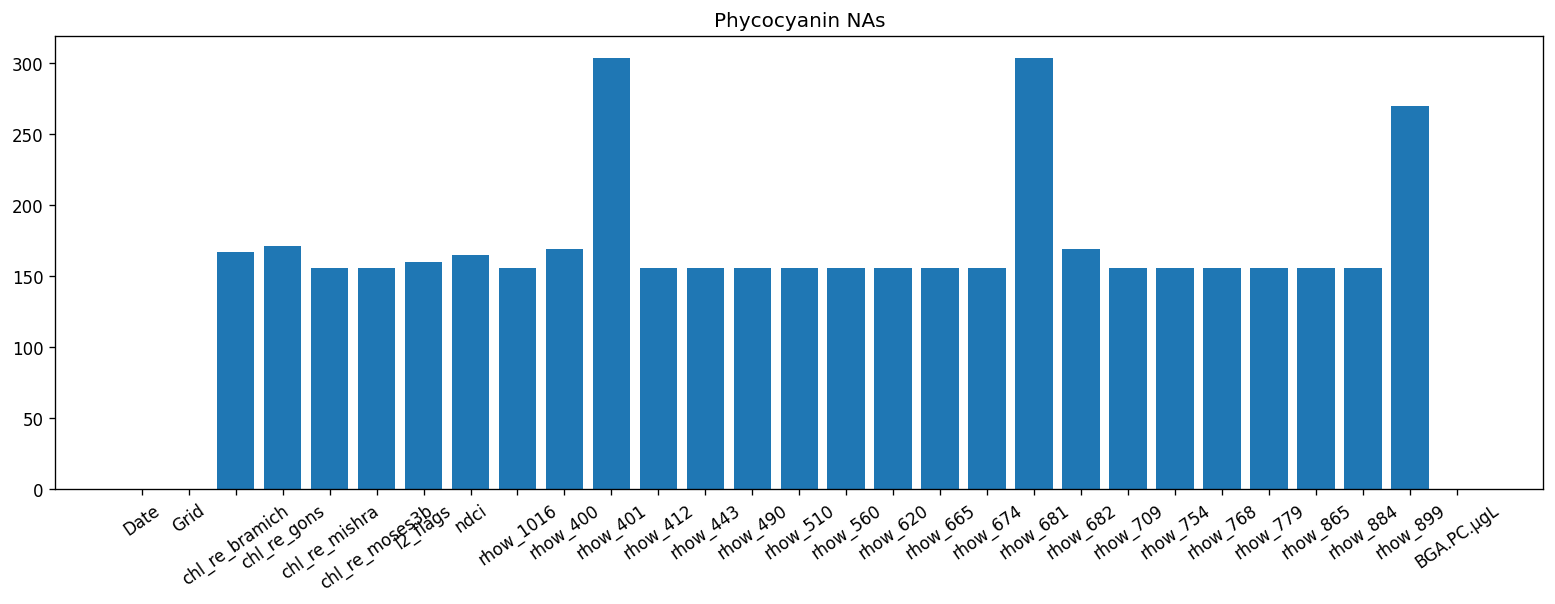

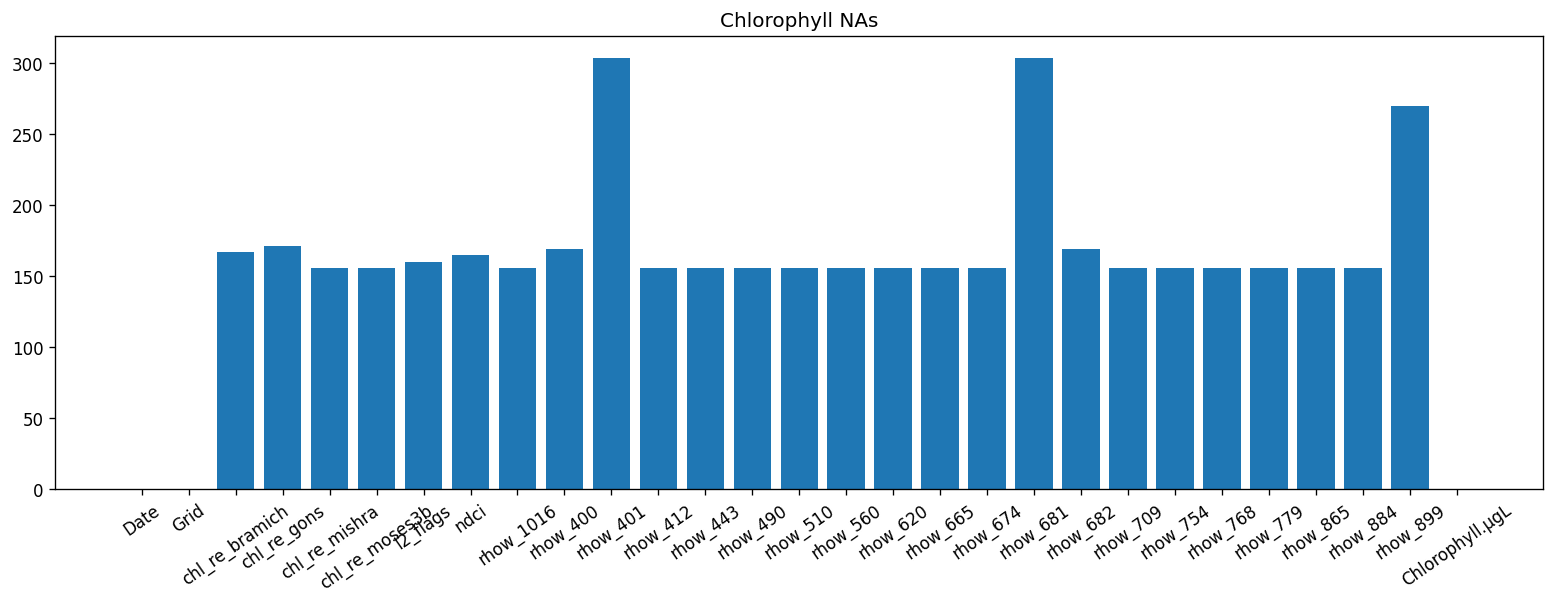

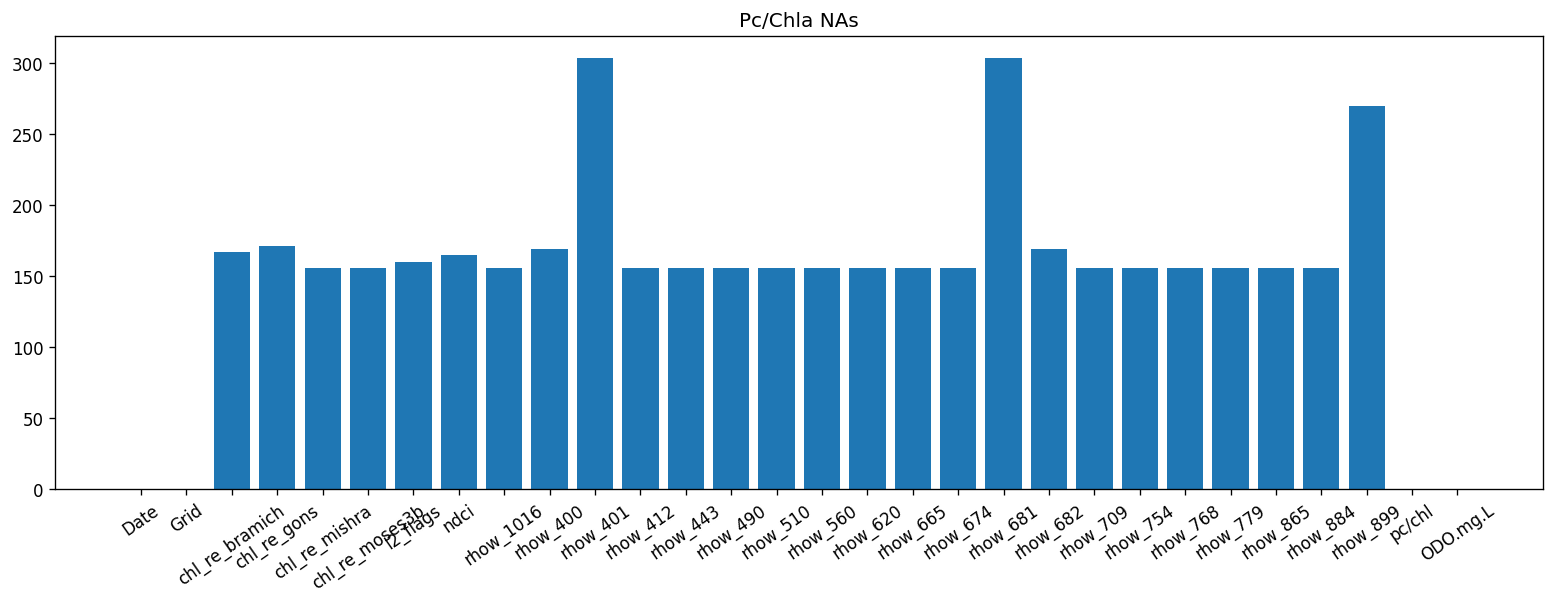

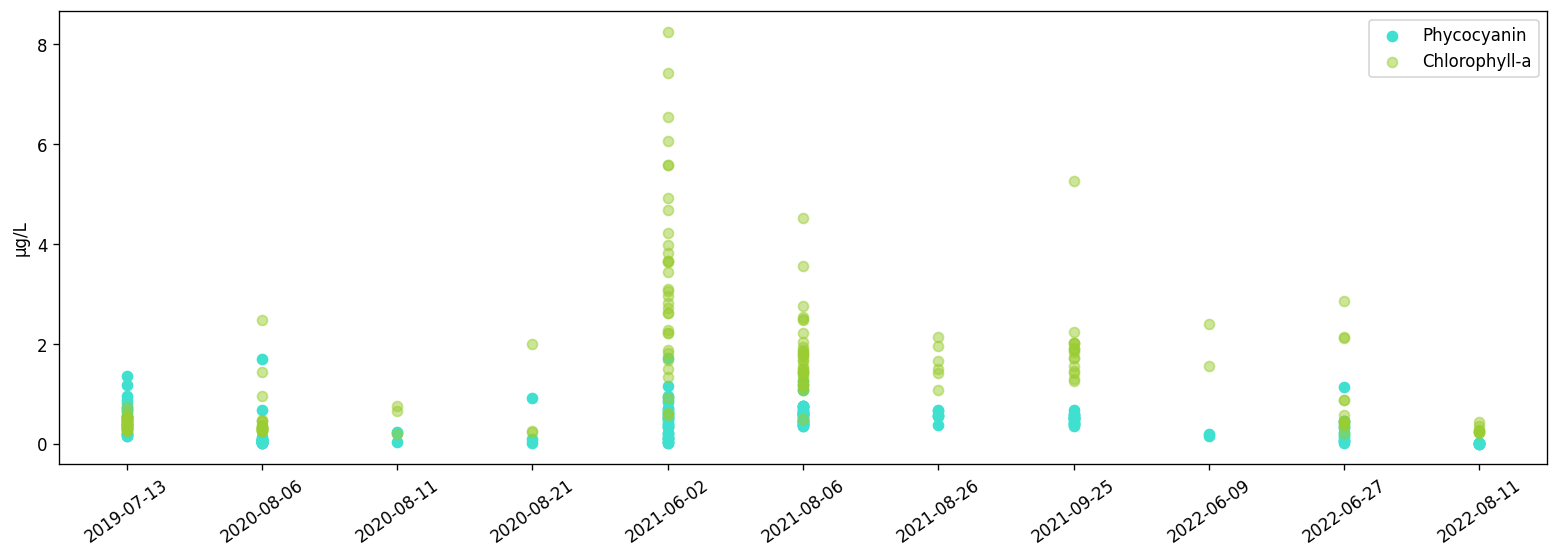

In [8]:
#Get data ready
out_wide=output.pivot_table(index=['Date','Grid'], columns='Band', values='data')

dropnum = 156 #Number of Nas over which we get rid of the column

#####Phycocyanin
s3_wide=pd.merge(out_wide, df2.loc[:,['Date','Grid','BGA.PC.µgL']], on=['Date','Grid'])
figure(figsize=(16, 5), dpi=120)
plt.xticks(rotation=35)
plt.bar(x=s3_wide.columns,height=s3_wide[s3_wide.columns].isna().sum())
plt.title("Phycocyanin NAs")

#rhow_401, rhow_681, rhow_899 many NAs
s3_wide=s3_wide.drop(["l2_flags"],axis=1)

bandMath=band_algos(s3_wide)
bandMath=pd.DataFrame(bandMath)
bandMath=bandMath.T
bandMath.columns=algoNames

s3_wide=pd.concat([s3_wide,bandMath],axis=1,ignore_index=False)

pred_dates = s3_wide['Date']

drops=s3_wide[s3_wide.columns].isna().sum()>dropnum
drops = s3_wide.columns[drops]

s3_wide=s3_wide.drop(columns=drops)
s3_wide = s3_wide.dropna()


Xp=s3_wide.drop(columns=['BGA.PC.µgL','Date','Grid'])
Yp=s3_wide['BGA.PC.µgL']




#####Chlorophyll
s3_wide=pd.merge(out_wide, df2.loc[:,['Date','Grid','Chlorophyll.µgL']], on=['Date','Grid'])
figure(figsize=(16, 5), dpi=120)
plt.xticks(rotation=35)
plt.bar(x=s3_wide.columns,height=s3_wide[s3_wide.columns].isna().sum())
plt.title("Chlorophyll NAs")

#rhow_401, rhow_681, rhow_899 many NAs
s3_wide=s3_wide.drop(["l2_flags"],axis=1)

bandMath=band_algos(s3_wide)
bandMath=pd.DataFrame(bandMath)
bandMath=bandMath.T
bandMath.columns=algoNames

s3_wide=pd.concat([s3_wide,bandMath],axis=1,ignore_index=False)

pred_dates = s3_wide['Date']

drops=s3_wide[s3_wide.columns].isna().sum()>dropnum
drops = s3_wide.columns[drops]

s3_wide=s3_wide.drop(columns=drops)
s3_wide = s3_wide.dropna()

Xc=s3_wide.drop(columns=['Chlorophyll.µgL','Date','Grid'])
Yc=s3_wide['Chlorophyll.µgL']






#####PC/CHLa (also get ODO)
df2['pc/chl']=df2['BGA.PC.µgL']/df2['Chlorophyll.µgL']
s3_wide=pd.merge(out_wide, df2.loc[:,['Date','Grid','pc/chl','ODO.mg.L']], on=['Date','Grid'])
figure(figsize=(16, 5), dpi=120)
plt.xticks(rotation=35)
plt.bar(x=s3_wide.columns,height=s3_wide[s3_wide.columns].isna().sum())
plt.title("Pc/Chla NAs")

#rhow_401, rhow_681, rhow_899 many NAs
s3_wide=s3_wide.drop(["l2_flags"],axis=1)

bandMath=band_algos(s3_wide)
bandMath=pd.DataFrame(bandMath)
bandMath=bandMath.T
bandMath.columns=algoNames

s3_wide=pd.concat([s3_wide,bandMath],axis=1,ignore_index=False)

pred_dates = s3_wide['Date']

drops=s3_wide[s3_wide.columns].isna().sum()>dropnum
drops = s3_wide.columns[drops]

s3_wide=s3_wide.drop(columns=drops)
s3_wide = s3_wide.dropna()

grid = s3_wide['Grid']

Xpc=s3_wide.drop(columns=['pc/chl','ODO.mg.L','Date','Grid'])
Ypc=s3_wide['pc/chl']
odo = s3_wide['ODO.mg.L']



predictors = [Xc,Xp,Xpc]
predictands = [Yc,Yp,Ypc]



figure(figsize=(16, 5), dpi=120)
plt.xticks(rotation=35)
plt.scatter(s3_wide['Date'],Yp, label="Phycocyanin",facecolor="turquoise")
plt.scatter(s3_wide['Date'],Yc, label="Chlorophyll-a",facecolor="yellowgreen",alpha=0.5)
plt.ylabel('µg/L')
plt.legend()

set(s3_wide['Date'])

print('number of data points: ', len(s3_wide))
print('number of columns: ',len(s3_wide.columns))


### Random Forest

Stick with Variable selection

['chl_re_bramich', 'r560-(r665+r443-r665)']
Pearson R (0.8003718147654116, 5.702892090219802e-10)
R-square 0.6174137870225852
MAE 0.5276210861451757
Number of test points:  40
['rhow_400', 'rhow_412']
Pearson R (0.4209284543574593, 0.006836481662200622)
R-square -0.17629972900966262
MAE 0.21769264956116952
Number of test points:  40
['chl_re_bramich', 'chl_re_moses3b', 'rhow_412', 'rhow_560', 'r865-r665/r443+r508', 'r560-(r665+r443-r665)', 'r620-(r709+r560-r709)', 'r708-r620']
Pearson R (0.771128773908662, 5.806646761051439e-09)
R-square 0.52609895529351
MAE 0.19086089564740208
Number of test points:  40


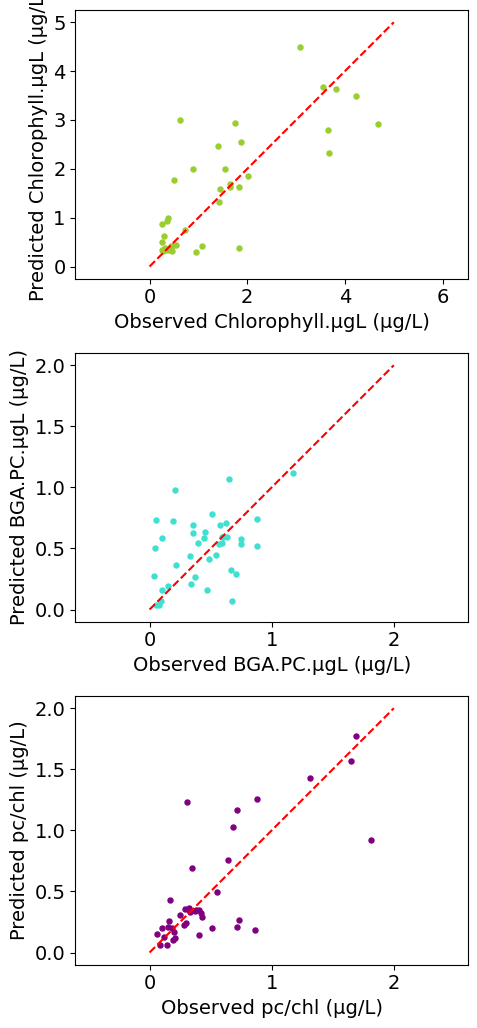

In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from numpy import mean
from numpy import std
from numpy import arange
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from boruta import BorutaPy
import sys
import sklearn.neighbors._base
import joblib
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

rf_testout = {}
rf_predout = {}

modelType = ['chl','pc','pcchl']

predictand_names = ['Chlorophyll.µgL','BGA.PC.µgL',"pc/chl"]
cols = ['yellowgreen','turquoise','purple']
num=[0,1,2]
lims = [range(0,6),range(0,3),range(0,3)]

predsRF =[]
r2RF = []
bestPreds = []

fig, axs = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(5, 10.5, forward=True)
axs=axs.flatten()

for X, Y, i in zip(predictors, predictands,num):

    
    #Scale data
    scaler = StandardScaler()
    scaler.fit(X)
    Xsc=scaler.transform(X)
    X_train, X_test, Y_train, Y_test, = train_test_split(Xsc, Y, test_size=0.3, random_state=42)
    
    
    # Impute our data, then train
    X_train = pd.DataFrame(X_train)
    X_train.columns = X.columns
    
    X_test = pd.DataFrame(X_test)
    X_test.columns = X.columns
    
    Xsc = pd.DataFrame(Xsc)
    Xsc.columns = X.columns


    rfr = RandomForestRegressor(max_depth=None,n_estimators=500)

    #Feature selection - Boruta
    feat_selector = BorutaPy(rfr, random_state=41, verbose=0, n_estimators='auto')
    sel = feat_selector.fit(np.array(X_train), np.array(Y_train))

    best = list(X_train.columns[feat_selector.ranking_<=2])
    print(best)

    rfr.fit(X_train[best], Y_train)

    X_test_imp = X_test
    y_pred = rfr.predict(X_test[best])

    xy_line = lims[i]
    axs[i].plot(xy_line, 'r--')
    axs[i].scatter(Y_test,y_pred, s=13, facecolor=cols[i])
    axs[i].axis('equal')
    axs[i].set_xlabel('Observed'+' '+Y.name+' '+'(µg/L)')
    axs[i].set_ylabel('Predicted'+' '+Y.name+' '+'(µg/L)')
    #axs[i].annotate(r2_score(Y_test,y_pred),(2,2))
    #axs[i].set_title('Sentinel 3, Random Forest 70-30% split')
    

    print('Pearson R',pearsonr(y_pred, Y_test)) #r, p
    print('R-square',r2_score(Y_test,y_pred))
    print('MAE',mean_absolute_error(Y_test,y_pred))
    print('Number of test points: ',len(X_test))
    
    r2RF.append(r2_score(Y_test,y_pred))
    
    yAll=rfr.predict(Xsc[best])

    joblib.dump(rfr, modelType[i]+"_rf.joblib")
    
    bestPreds.append(best)
    predsRF.append(yAll)
    
    rf_testout[predictand_names[i]] = Y_test
    rf_predout[predictand_names[i]] = y_pred
    
fig.tight_layout()
plt.show()

Cross validation approach

                       count
rhow_560                   5
r560-(r665+r443-r665)      5
r620-(r709+r560-r709)      5
Fold Average Pearson R 0.33727230556166565
Fold Average R-square 0.4222074317426777
Fold Average MAE 0.7176351209645357
                     count
rhow_412                 5
rhow_443                 5
r865-r665/r443+r508      5
Fold Average Pearson R 0.251407012006901
Fold Average R-square 0.09299443624084285
Fold Average MAE 0.224449033812986
                       count
r865-r665/r443+r508        5
r620-(r709+r560-r709)      5
r708-r620                  5
Fold Average Pearson R 0.3720337728949895
Fold Average R-square 0.4072427307977122
Fold Average MAE 0.18251155028553157


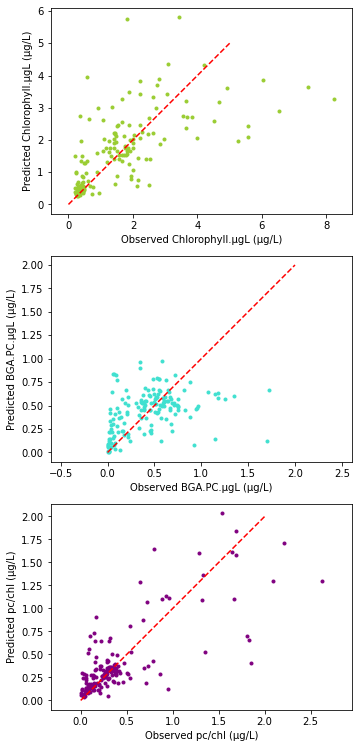

In [9]:
from sklearn.model_selection import RepeatedKFold
from itertools import chain
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from numpy import mean
from numpy import std
from numpy import arange
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from boruta import BorutaPy
import sys
import sklearn.neighbors._base
import joblib
from collections import Counter
from itertools import chain

odo = s3_wide['ODO.mg.L']
grid=s3_wide['Grid']
rf_testout = {}
rf_predout = {}
rf_gridout = {}

modelType = ['chl','pc','pcchl']

predictand_names = ['Chlorophyll.µgL','BGA.PC.µgL',"pc/chl"]
cols = ['yellowgreen','turquoise','purple']
num=[0,1,2]
lims = [range(0,6),range(0,3),range(0,3)]

bestPreds = []



fig, axs = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(5, 10.5, forward=True)
axs=axs.flatten()


for X, Y, i in zip(predictors, predictands,num):
    #Scale data
    scaler = StandardScaler()
    scaler.fit(X)
    Xsc=scaler.transform(X)

    Xsc = pd.DataFrame(Xsc)
    Xsc.columns = X.columns

    kfoldBest=[]
    kfoldPreds=[]
    fold=[]
    
    r2RF=[]
    pr=[]
    mae=[]
    
    predsRF=pd.DataFrame({'test' : [],'pred' : []})
    odo_cv_rf=pd.DataFrame({'ODO.mg.L' : []})
    grid_cv_rf=pd.DataFrame({'Grid' : []})
    
    random_state = 3
    splits=5
    rkf = RepeatedKFold(n_splits=splits, n_repeats=1, random_state=random_state)
    for j,(train, test) in enumerate(rkf.split(Xsc)):

        X_train, X_test, Y_train, Y_test, odo_test, grid_test = Xsc.iloc[train], Xsc.iloc[test], Y.iloc[train], Y.iloc[test], odo.iloc[test], grid.iloc[test]

        rfr = RandomForestRegressor(max_depth=None,n_estimators=500)

        #Feature selection - Boruta
        feat_selector = BorutaPy(rfr, random_state=random_state, verbose=0, n_estimators='auto')
        sel = feat_selector.fit(np.array(X_train), np.array(Y_train))

        best = list(X_train.columns[feat_selector.ranking_<=2])
        kfoldBest.append(best)

        rfr.fit(X_train[best], Y_train)

        y_pred = rfr.predict(X_test[best])
        foldResults=pd.DataFrame(zip(Y_test,y_pred), columns = ['test','pred'])
        
        fold.append([j]*len(X_test))
        pr.append(pearsonr(Y_test,y_pred))
        r2RF.append(r2_score(Y_test,y_pred))
        mae.append(mean_absolute_error(Y_test,y_pred))
        
        odo_cv_rf=pd.concat([odo_cv_rf,pd.DataFrame(odo_test)],axis=0) #to keep track of data pairs
        grid_cv_rf=pd.concat([grid_cv_rf,pd.DataFrame(grid_test)],axis=0) #to keep track of data pairs
        predsRF=pd.concat([predsRF,foldResults],axis=0)
    
    
    #Look at most common predictors slected
    a=list(chain.from_iterable(kfoldBest))
    a = dict(Counter(a))
    count=pd.DataFrame.from_dict(a, orient='index',columns=["count"])
    count.sort_values(by="count",ascending=False)

    finalVars=count[count['count']==splits]
    print(finalVars)
    
    bestPreds.append(list(finalVars.index))

    xy_line = lims[i]
    axs[i].plot(xy_line, 'r--')
    axs[i].scatter(predsRF['test'],predsRF['pred'], s=9, facecolor=cols[i])
    #axs[i].scatter(predsRF['test'],predsRF['pred'], s=9,c=np.array(list(chain(*fold))))
    axs[i].axis('equal')
    axs[i].set_xlabel('Observed'+' '+Y.name+' '+'(µg/L)')
    axs[i].set_ylabel('Predicted'+' '+Y.name+' '+'(µg/L)')
    

    print('Fold Average Pearson R',np.mean(pr)) #r, p
    print('Fold Average R-square',np.mean(r2RF))
    print('Fold Average MAE',np.mean(mae))

    #joblib.dump(rfr, modelType[i]+"_rf.joblib")
    
    bestPreds.append(best)
    predsRF.append(kfoldPreds)
    
    rf_testout[predictand_names[i]] = predsRF['test']
    rf_predout[predictand_names[i]] = predsRF['pred']
    rf_gridout[predictand_names[i]] = grid_cv_rf['Grid']
    
        

fig.tight_layout()
plt.show()


### Artificial Neural Network

Training - stick with the variable selection

In [108]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense

np.random.seed(5)

# let's create a function that creates the model (required for KerasClassifier) 
# while accepting the hyperparameters we want to tune 
# we also pass some default values such as optimizer='rmsprop'
def create_model(optimizer='adam', init='uniform'):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, kernel_initializer=init, activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(num_classes, kernel_initializer=init))

    # compile model
    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, 
                  metrics=['MeanAbsoluteError'])

    return model



#Now use Grid CV to evaluate ANN options on training set
bestParams=[]

for X, Y, i in zip(predictors, predictands, num):
    #Scale data
    scaler = StandardScaler()
    scaler.fit(X)
    Xsc=scaler.transform(X)

    X_train, X_test, Y_train, Y_test = train_test_split(Xsc, Y, test_size=0.3, random_state=42)

    X_train = pd.DataFrame(X_train)
    X_train.columns = X.columns
    X_test = pd.DataFrame(X_test)
    X_test.columns = X.columns

    Xsc = pd.DataFrame(Xsc)
    Xsc.columns = X.columns

    
    best=bestPreds[i]


    #Evaluating NN models
    # repeat some of the initial values here so we make sure they were not changed
    input_dim = X_train[best].shape[1] #using best subset from RF here
    num_classes = 1


    # fix random seed for reproducibility (this might work or might not work 
    # depending on each library's implementation)
    seed = 7
    np.random.seed(seed)

    # create the sklearn model for the network
    model_init_batch_epoch_CV = KerasRegressor(build_fn=create_model, verbose=1)

    # we choose the initializers that came at the top in our previous cross-validation!!
    #init_mode = ['he_uniform', 'uniform', 'he_normal'] 
    #init_mode = ['uniform', 'glorot_normal'] 
    init_mode = ['uniform','normal'] 
    batches = [20,70]
    epochs = [500]


    # grid search for initializer, batch size and number of epochs
    param_grid = dict(epochs=epochs, batch_size=batches, init=init_mode)
    grid = GridSearchCV(estimator=model_init_batch_epoch_CV, 
                        param_grid=param_grid,
                        cv=3)

    grid_result = grid.fit(X_train[best], Y_train)

    # print results
    print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print(f'mean={mean:.4}, std={stdev:.4} using {param}')
        
    bestParams.append(grid_result.best_params_)

print(bestParams)
#Best Accuracy for -0.09257 using {'batch_size': 70, 'epochs': 500, 'init': 'normal'}

Epoch 1/500
3/3 [==============================] - 0s 2ms/step - loss: 5.2272 - mean_absolute_error: 1.7281
Epoch 2/500
3/3 [==============================] - 0s 2ms/step - loss: 5.1887 - mean_absolute_error: 1.7171
Epoch 3/500
3/3 [==============================] - 0s 2ms/step - loss: 5.1456 - mean_absolute_error: 1.7044
Epoch 4/500
3/3 [==============================] - 0s 2ms/step - loss: 5.0903 - mean_absolute_error: 1.6878
Epoch 5/500
3/3 [==============================] - 0s 2ms/step - loss: 5.0146 - mean_absolute_error: 1.6670
Epoch 6/500
3/3 [==============================] - 0s 2ms/step - loss: 4.9204 - mean_absolute_error: 1.6397
Epoch 7/500
3/3 [==============================] - 0s 2ms/step - loss: 4.8083 - mean_absolute_error: 1.6052
Epoch 8/500
3/3 [==============================] - 0s 2ms/step - loss: 4.6615 - mean_absolute_error: 1.5617
Epoch 9/500
3/3 [==============================] - 0s 2ms/step - loss: 4.4880 - mean_absolute_error: 1.5082
Epoch 10/500
3/3 [==========

3/3 [==============================] - 0s 3ms/step - loss: 1.3011 - mean_absolute_error: 0.7216
Epoch 151/500
3/3 [==============================] - 0s 2ms/step - loss: 1.3069 - mean_absolute_error: 0.7279
Epoch 152/500
3/3 [==============================] - 0s 2ms/step - loss: 1.2983 - mean_absolute_error: 0.7296
Epoch 153/500
3/3 [==============================] - 0s 3ms/step - loss: 1.2964 - mean_absolute_error: 0.7274
Epoch 154/500
3/3 [==============================] - 0s 2ms/step - loss: 1.3032 - mean_absolute_error: 0.7248
Epoch 155/500
3/3 [==============================] - 0s 3ms/step - loss: 1.2915 - mean_absolute_error: 0.7188
Epoch 156/500
3/3 [==============================] - 0s 3ms/step - loss: 1.2892 - mean_absolute_error: 0.7194
Epoch 157/500
3/3 [==============================] - 0s 2ms/step - loss: 1.2872 - mean_absolute_error: 0.7180
Epoch 158/500
3/3 [==============================] - 0s 2ms/step - loss: 1.2906 - mean_absolute_error: 0.7213
Epoch 159/500
3/3 [=====

3/3 [==============================] - 0s 2ms/step - loss: 1.0719 - mean_absolute_error: 0.6774
Epoch 299/500
3/3 [==============================] - 0s 2ms/step - loss: 1.0733 - mean_absolute_error: 0.6728
Epoch 300/500
3/3 [==============================] - 0s 2ms/step - loss: 1.0733 - mean_absolute_error: 0.6724
Epoch 301/500
3/3 [==============================] - 0s 2ms/step - loss: 1.0679 - mean_absolute_error: 0.6689
Epoch 302/500
3/3 [==============================] - 0s 2ms/step - loss: 1.0705 - mean_absolute_error: 0.6703
Epoch 303/500
3/3 [==============================] - 0s 2ms/step - loss: 1.0685 - mean_absolute_error: 0.6716
Epoch 304/500
3/3 [==============================] - 0s 2ms/step - loss: 1.0677 - mean_absolute_error: 0.6665
Epoch 305/500
3/3 [==============================] - 0s 2ms/step - loss: 1.0628 - mean_absolute_error: 0.6649
Epoch 306/500
3/3 [==============================] - 0s 2ms/step - loss: 1.0670 - mean_absolute_error: 0.6657
Epoch 307/500
3/3 [=====

KeyboardInterrupt: 

**ANN Training results**

Chl: 'batch_size': 20, 'epochs': 500, 'init': 'uniform' 

Pc:  'batch_size': 20, 'epochs': 500, 'init': 'uniform'

Pc/Chl: 'batch_size': 70, 'epochs': 500, 'init': 'normal'

#### Train-Test split ANN Models

Pearson R (0.5978891444557825, 4.621176971396562e-05)
MAE 0.9630217603981723
R-square 0.022551527473212873
Saved chl model to disk
Pearson R (0.5292513589475886, 0.00044572118244221953)
MAE 0.2100417801420913
R-square 0.27259165971640165
Saved pc model to disk
Pearson R (0.7388415059445584, 5.2255669911421115e-08)
MAE 0.22376223774492376
R-square 0.4212730721770086
Saved pcchl model to disk


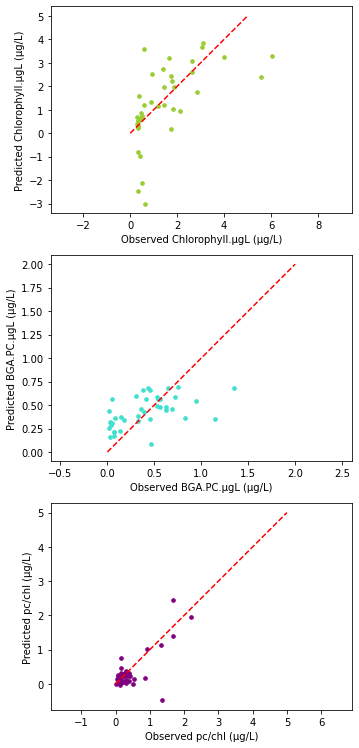

In [113]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

np.random.seed(5)

ann_testout = {}
ann_predout = {}

predsANN=[]
r2ANN = []

modelType = ['chl','pc','pcchl']
cols = ['yellowgreen','turquoise','purple']
num=[0,1,2]
lims = [range(0,6),range(0,3),range(0,6)]

fig, axs = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(5, 10.5, forward=True)
axs=axs.flatten()

for X, Y, i in zip(predictors, predictands, num):
    #Scale data
    scaler = StandardScaler()
    scaler.fit(X)
    Xsc=scaler.transform(X)

    X_train, X_test, Y_train, Y_test = train_test_split(Xsc, Y, test_size=0.3, random_state=41)

    # Impute our data, then train
    X_train = pd.DataFrame(X_train)
    X_train.columns = X.columns
    
    X_test = pd.DataFrame(X_test)
    X_test.columns = X.columns
    
    Xsc = pd.DataFrame(Xsc)
    Xsc.columns = X.columns

    
    best=bestPreds[i]

    #Evaluating ANN models
    # repeat some of the initial values here so we make sure they were not changed
    input_dim = X_train.shape[1]
    num_classes = 1

    #final model
    model = Sequential()
    model.add(Dense(128, input_dim=len(X[best].columns), kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train[best], Y_train, epochs=500, verbose=0, batch_size=20)


    y_pred = model.predict(X_test[best])
    y_pred=y_pred.squeeze()
    print('Pearson R',pearsonr(Y_test, y_pred)) #r, p
    print('MAE',mean_absolute_error(Y_test,y_pred))
    print('R-square',r2_score(Y_test,y_pred))

    xy_line = lims[i]
    axs[i].plot(xy_line, 'r--')
    axs[i].scatter(Y_test,y_pred, s=13, facecolor=cols[i])
    axs[i].axis('equal')
    axs[i].set_xlabel('Observed'+' '+Y.name+' '+'(µg/L)')
    axs[i].set_ylabel('Predicted'+' '+Y.name+' '+'(µg/L)')
    
    # serialize model to JSON
    model_json = model.to_json()
    with open(modelType[i]+"_ANN.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(modelType[i]+"_ANN.h5")
    print("Saved "+modelType[i]+" model to disk")

    
    r2ANN.append(r2_score(Y_test,y_pred))

    yAll=model.predict(Xsc[best])
    predsANN.append(yAll)
    
    ann_testout[predictand_names[i]] = Y_test
    ann_predout[predictand_names[i]] = y_pred

fig.tight_layout()
plt.show()


#### Cross Validation ANN Models

Fold Average Pearson R [0.35475025547512473]
Fold Average R-square 0.4207981585299425
Fold Average MAE 0.7539683822437244
Fold Average Pearson R [0.27768470878236295]
Fold Average R-square 0.20982808567450523
Fold Average MAE 0.20821436029199952
Fold Average Pearson R [0.31325732349026136]
Fold Average R-square 0.30818470832541683
Fold Average MAE 0.23995859006090953


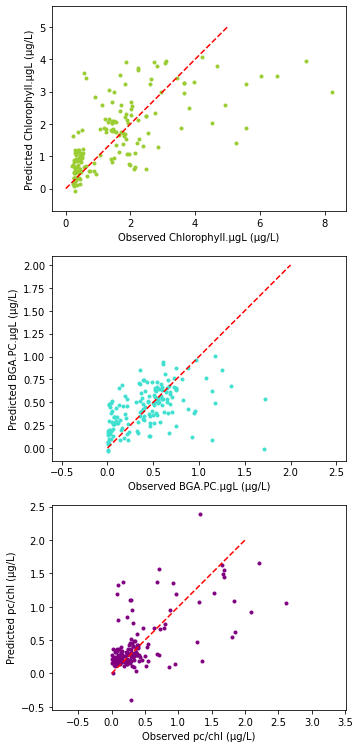

In [10]:
from sklearn.model_selection import RepeatedKFold
from itertools import chain
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

odo, grid = s3_wide['ODO.mg.L'], s3_wide['Grid']

ann_testout = {}
ann_predout = {}
ann_gridout = {}

modelType = ['chl','pc','pcchl']

predictand_names = ['Chlorophyll.µgL','BGA.PC.µgL',"pc/chl"]
cols = ['yellowgreen','turquoise','purple']
num=[0,1,2]
lims = [range(0,6),range(0,3),range(0,3)]


fig, axs = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(5, 10.5, forward=True)
axs=axs.flatten()


for X, Y, i in zip(predictors, predictands,num):
    #Scale data
    scaler = StandardScaler()
    scaler.fit(X)
    Xsc=scaler.transform(X)

    Xsc = pd.DataFrame(Xsc)
    Xsc.columns = X.columns

    kfoldBest=[]
    kfoldPreds=[]
    fold=[]
    
    r2ANN=[]
    pr=[]
    mae=[]
    
    predsANN=pd.DataFrame({'test' : [],'pred' : []})
    
    odo_cv_ann=pd.DataFrame({'ODO.mg.L' : []})
    grid_cv_ann=pd.DataFrame({'Grid' : []})
    
    random_state = 42
    rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=random_state)
    for j,(train, test) in enumerate(rkf.split(Xsc)):

        X_train, X_test, Y_train, Y_test, odo_test, grid_test = Xsc.iloc[train], Xsc.iloc[test], Y.iloc[train], Y.iloc[test], odo.iloc[test], grid.iloc[test]

        
        best=bestPreds[i]
        
        #Evaluating ANN models
        input_dim = X_train.shape[1]
        num_classes = 1

        #final model
        model = Sequential()
        model.add(Dense(128, input_dim=len(X[best].columns), kernel_initializer='normal', activation='relu'))
        model.add(Dense(64, kernel_initializer='normal'))
        model.add(Dense(1, kernel_initializer='normal'))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(X_train[best], Y_train, epochs=500, verbose=0, batch_size=20)
        
        
        y_pred = model.predict(X_test[best])
        foldResults=pd.DataFrame(zip(Y_test,y_pred), columns = ['test','pred'])
        
        fold.append([j]*len(X_test))
        pr.append(pearsonr(Y_test,y_pred))
        r2ANN.append(r2_score(Y_test,y_pred))
        mae.append(mean_absolute_error(Y_test,y_pred))
    
        
        #Save outputs
        odo_cv_ann=pd.concat([odo_cv_ann,pd.DataFrame(odo_test)],axis=0) #to keep track of data pairs
        grid_cv_ann=pd.concat([grid_cv_ann,pd.DataFrame(grid_test)],axis=0) #to keep track of data pairs
        predsANN=pd.concat([predsANN,foldResults],axis=0)
    
    
    xy_line = lims[i]
    axs[i].plot(xy_line, 'r--')
    axs[i].scatter(predsANN['test'],predsANN['pred'], s=9, facecolor=cols[i])
    #axs[i].scatter(predsRF['test'],predsRF['pred'], s=9,c=np.array(list(chain(*fold))))
    axs[i].axis('equal')
    axs[i].set_xlabel('Observed'+' '+Y.name+' '+'(µg/L)')
    axs[i].set_ylabel('Predicted'+' '+Y.name+' '+'(µg/L)')
    

    print('Fold Average Pearson R',np.mean(pr)) #r, p
    print('Fold Average R-square',np.mean(r2ANN))
    print('Fold Average MAE',np.mean(mae))
    
    ann_testout[predictand_names[i]] = predsANN['test']
    ann_predout[predictand_names[i]] = predsANN['pred']
    ann_gridout[predictand_names[i]] = grid_cv_ann['Grid']

    #joblib.dump(rfr, modelType[i]+"_rf.joblib")
    
        

fig.tight_layout()
plt.show()



Figures

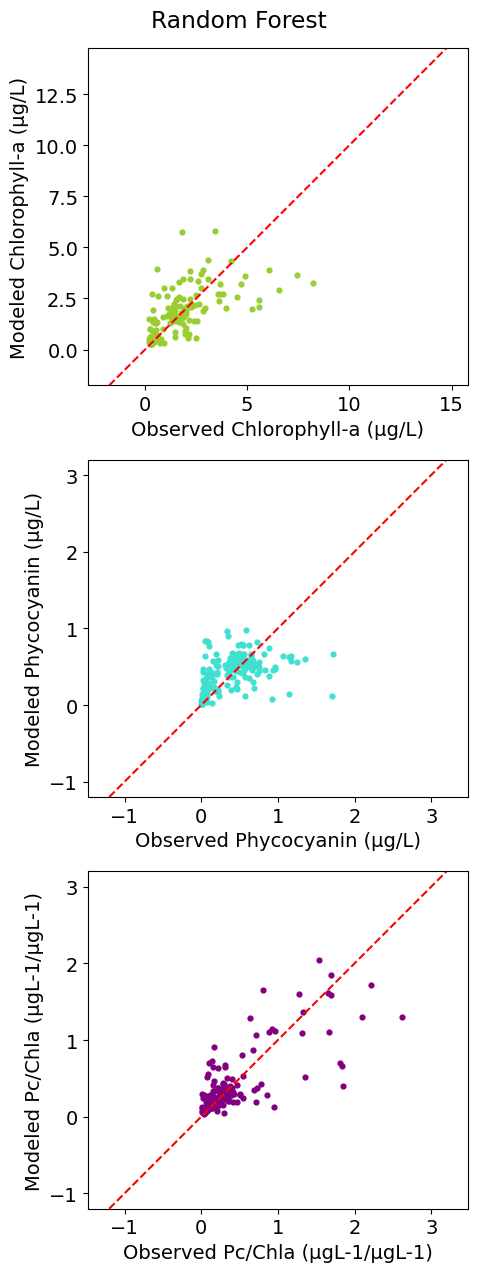

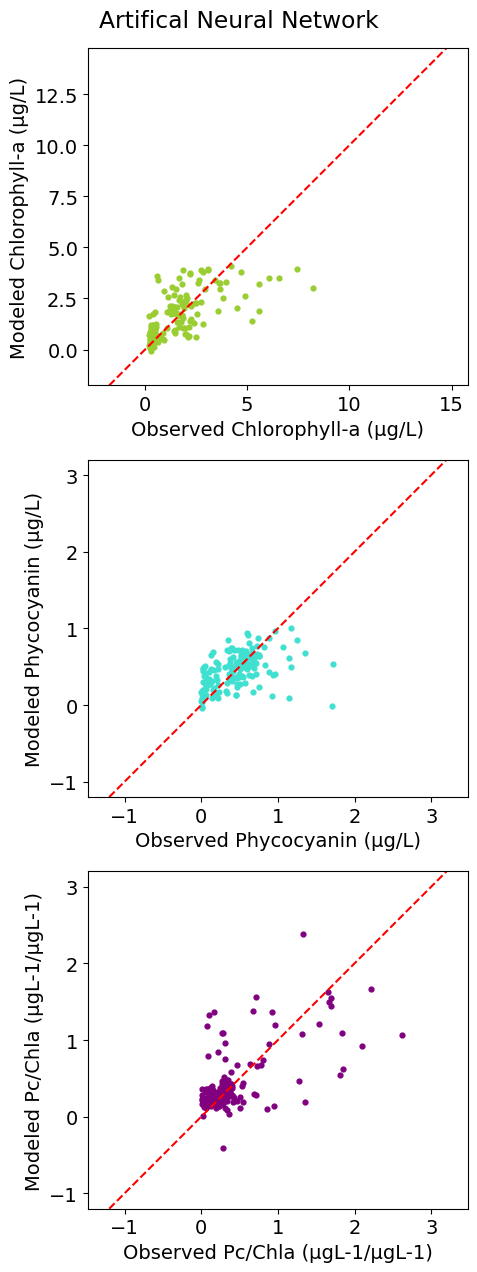

In [11]:
#Figures
import scipy.stats

# Styling
plt.style.use("default")
#plt.rcParams["font.family"] = "times"
plt.rcParams["font.size"] = 14


#RF

# Create Blank Figure
fig = plt.figure(figsize=(5, 13))
# Create 4x4 Grid
#gs = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[2, 1], width_ratios=[2, 1])
gs = fig.add_gridspec(nrows=3, ncols=1)

# Create Three Axes Objects
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])


# Plot Data
xy_line = range(0,14)
ax1.scatter(rf_testout['Chlorophyll.µgL'],rf_predout['Chlorophyll.µgL'], color="yellowgreen", linewidth=1,s=12)
ax1.axline((-1,-1),(14,14), linestyle='--',color='red')
ax1.set_xlabel('Observed Chlorophyll-a (µg/L)')
ax1.set_ylabel('Modeled Chlorophyll-a (µg/L)')
ax1.axis('equal')
#ax1.set_xlim([0,14])
#ax1.set_ylim([0,14])

xy_line = range(0,4)
ax2.scatter(rf_testout['BGA.PC.µgL'],rf_predout['BGA.PC.µgL'], color="turquoise", linewidth=1,s=12)
ax2.axline((-1,-1),(3,3), linestyle='--',color='red')
ax2.set_xlabel('Observed Phycocyanin (µg/L)')
ax2.set_ylabel('Modeled Phycocyanin (µg/L)')
ax2.axis('equal')
#ax2.set_xlim([0,3])
#ax2.set_ylim([0,3])


xy_line = range(0,4)
ax3.scatter(rf_testout['pc/chl'],rf_predout['pc/chl'], color="purple",s=12)
ax3.axline((-1,-1),(3,3), linestyle='--',color='red')
ax3.set_xlabel('Observed Pc/Chla (µgL-1/µgL-1)')
ax3.set_ylabel('Modeled Pc/Chla (µgL-1/µgL-1)')
ax3.axis('equal')
#ax3.set_xlim([0,4])
#ax3.set_ylim([0,4])

fig.suptitle("Random Forest")
fig.tight_layout()
plt.show()


#ANN

# Create Blank Figure
fig = plt.figure(figsize=(5, 13))
# Create 4x4 Grid
#gs = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[2, 1], width_ratios=[2, 1])
gs = fig.add_gridspec(nrows=3, ncols=1)

# Create Three Axes Objects
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])


# Plot Data
xy_line = range(0,14)
ax1.scatter(ann_testout['Chlorophyll.µgL'],ann_predout['Chlorophyll.µgL'], color="yellowgreen", linewidth=1,s=12)
ax1.axline((-1,-1),(14,14), linestyle='--',color='red')
ax1.set_xlabel('Observed Chlorophyll-a (µg/L)')
ax1.set_ylabel('Modeled Chlorophyll-a (µg/L)')
ax1.axis('equal')
#ax1.set_xlim([0,14])
#ax1.set_ylim([0,14])

xy_line = range(0,4)
ax2.scatter(ann_testout['BGA.PC.µgL'],ann_predout['BGA.PC.µgL'], color="turquoise", linewidth=1,s=12)
ax2.axline((-1,-1),(3,3), linestyle='--',color='red')
ax2.set_xlabel('Observed Phycocyanin (µg/L)')
ax2.set_ylabel('Modeled Phycocyanin (µg/L)')
ax2.axis('equal')
#ax2.set_xlim([0,3])
#ax2.set_ylim([0,3])


xy_line = range(0,4)
ax3.scatter(ann_testout['pc/chl'],ann_predout['pc/chl'], color="purple",s=12)
#ax3.plot(xy_line, 'r--')
ax3.axline((-1,-1),(3,3), linestyle='--',color='red')
ax3.set_xlabel('Observed Pc/Chla (µgL-1/µgL-1)')
ax3.set_ylabel('Modeled Pc/Chla (µgL-1/µgL-1)')
ax3.axis('equal')
#ax3.set_xlim([0,4])
#ax3.set_ylim([0,4])

fig.suptitle("Artifical Neural Network")
fig.tight_layout()
plt.show()




Best Models

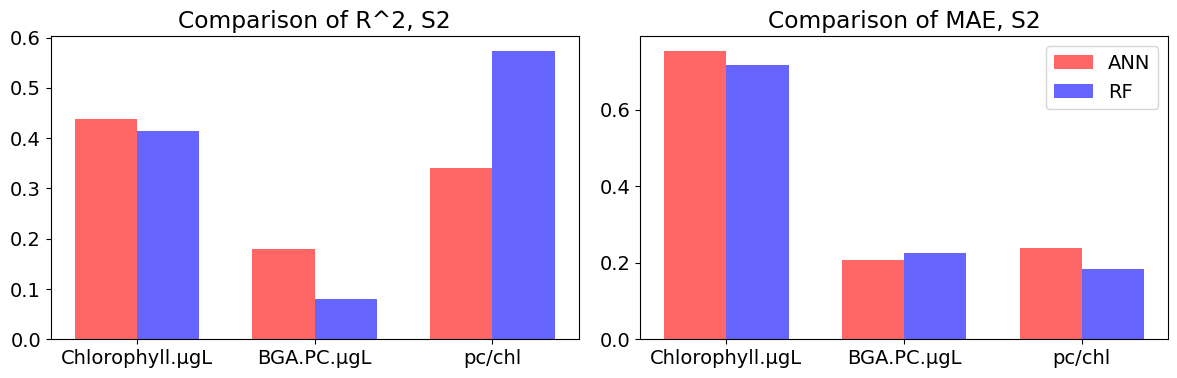

In [12]:

maeANN, r2ANN, maeRF, r2RF, var = [], [], [], [], []
for key in rf_predout:
    r2RF.append(r2_score(rf_testout[key],rf_predout[key]))
    r2ANN.append(r2_score(ann_testout[key],ann_predout[key]))
    
    maeRF.append(mean_absolute_error(rf_testout[key],rf_predout[key]))
    maeANN.append(mean_absolute_error(ann_testout[key],ann_predout[key]))
    
    var.append(key)

  


fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 4)
ind = np.arange(len(var))
bar_width = 0.35
opacity = 0.6
rects1 = ax[0].bar(ind, r2ANN, bar_width,
                alpha=opacity, color='r')
rects2 = ax[0].bar(ind+bar_width, r2RF, bar_width,
                alpha=opacity, color='b')
ax[0].set_title('Comparison of R^2, S2')
ax[0].set_xticks(ind + bar_width/2)
ax[0].set_xticklabels(var)



rects3 = ax[1].bar(ind, maeANN, bar_width,
                alpha=opacity, color='r', label='ANN')
rects4 = ax[1].bar(ind+bar_width, maeRF, bar_width,
                alpha=opacity, color='b', label='RF')
ax[1].set_title('Comparison of MAE, S2')
ax[1].set_xticks(ind + bar_width/2)
ax[1].set_xticklabels(var)
ax[1].legend()

fig.tight_layout()
plt.show()


r2results=pd.DataFrame(zip(var,r2ANN,r2RF), columns=["var",'ANN','RF'])

names = ['Chlorophyll.µgL_o','Chlorophyll.µgL_p','grid','BGA.PC.µgL_o','BGA.PC.µgL_p','grid','pc/chl_p','pc/chl_o','grid']

chl=pd.DataFrame(zip(pd.DataFrame.from_dict(ann_testout)['Chlorophyll.µgL'], #ANN best for chl
                pd.DataFrame.from_dict(ann_predout)['Chlorophyll.µgL'],
                pd.DataFrame.from_dict(ann_gridout)['Chlorophyll.µgL']),
                columns=names[0:3])



pc=pd.DataFrame(zip(pd.DataFrame.from_dict(ann_testout)['BGA.PC.µgL'], #ANN best for pc
                pd.DataFrame.from_dict(ann_predout)['BGA.PC.µgL'],
                pd.DataFrame.from_dict(ann_gridout)['BGA.PC.µgL']),
                columns=names[3:6])

                
pcchl=pd.DataFrame(zip(pd.DataFrame.from_dict(rf_testout)['pc/chl'], #RF best for pc/chl
                pd.DataFrame.from_dict(rf_predout)['pc/chl'],
                pd.DataFrame.from_dict(rf_gridout)['pc/chl']),
                columns=names[6:9])


chl=chl.sort_values(by='grid',ignore_index=True)
pc=pc.sort_values(by='grid',ignore_index=True)
pcchl=pcchl.sort_values(by='grid',ignore_index=True)

algaePreds=pd.concat([chl,pc,pcchl],axis=1)




### Dissolved Oxygen 

Not working out very well so far...

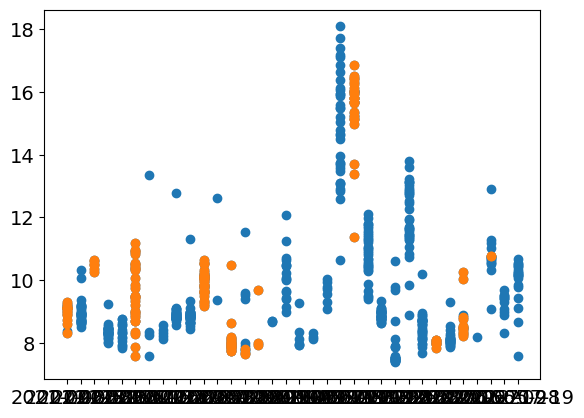

['Chlorophyll.µgL', 'BGA.PC.µgL', 'pc/chl']

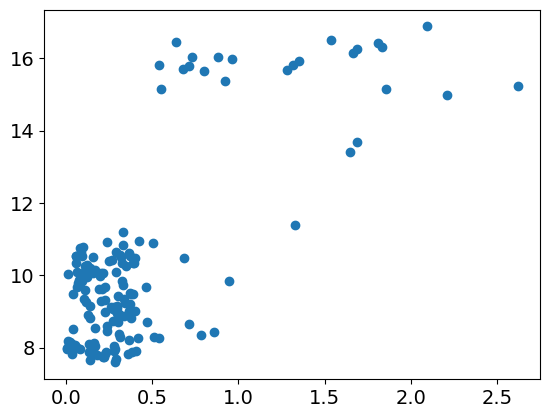

In [15]:
#plt.scatter(df2['Date'],df2['Chlorophyll.RFU'])
plt.scatter(df2['Date'],df2['ODO.mg.L'])
plt.scatter(s3_wide['Date'],s3_wide['ODO.mg.L'])
plt.show()
plt.scatter(s3_wide['pc/chl'],s3_wide['ODO.mg.L'])




In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense

np.random.seed(5)

# let's create a function that creates the model (required for KerasClassifier) 
# while accepting the hyperparameters we want to tune 
# we also pass some default values such as optimizer='rmsprop'
def create_model(optimizer='adam', init='uniform'):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, kernel_initializer=init, activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(num_classes, kernel_initializer=init))

    # compile model
    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, 
                  metrics=['MeanAbsoluteError'])

    return model



#Now use Grid CV to evaluate ANN options on training set
bestParams=[]


#Scale data
scaler = StandardScaler()
scaler.fit(df2[algae])
Xsc=scaler.transform(df2[algae])

X_train, X_test, Y_train, Y_test = train_test_split(Xsc, Y, test_size = 0.3, random_state=42)

X_train = pd.DataFrame(X_train)
X_train.columns = algae
X_test = pd.DataFrame(X_test)
X_test.columns = algae

Xsc = pd.DataFrame(Xsc)
Xsc.columns = algae



#Evaluating NN models
# repeat some of the initial values here so we make sure they were not changed
input_dim = X_train.shape[1] #using best subset from RF here
num_classes = 1


# fix random seed for reproducibility (this might work or might not work 
# depending on each library's implementation)
seed = 7
np.random.seed(seed)

# create the sklearn model for the network
model_init_batch_epoch_CV = KerasRegressor(build_fn=create_model, verbose=1)

# we choose the initializers that came at the top in our previous cross-validation!!
#init_mode = ['he_uniform', 'uniform', 'he_normal'] 
#init_mode = ['uniform', 'glorot_normal'] 
init_mode = ['uniform','normal'] 
batches = [20,70]
epochs = [500]


# grid search for initializer, batch size and number of epochs
param_grid = dict(epochs=epochs, batch_size=batches, init=init_mode)
grid = GridSearchCV(estimator=model_init_batch_epoch_CV, 
                    param_grid=param_grid,
                    cv=3)

grid_result = grid.fit(X_train, Y_train)

# print results
print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'mean={mean:.4}, std={stdev:.4} using {param}')

bestParams.append(grid_result.best_params_)

print(bestParams)
#-2.678 using {'batch_size': 20, 'epochs': 500, 'init': 'normal'}

ValueError: Found input variables with inconsistent numbers of samples: [648, 161]

,TempC,ODO...sat,ODO.mg.L,SpCond.uS.cm,pH,...,Depth.m,Press.psi.a,BGA.PC.µgL,Chlorophyll.µgL,pc/chl
Grid,,,,,,,,,,,
SpringHarbor,21.411067,99.498801,8.840569,149.013110,NaN,...,0.116216,0.164811,1.157937,7.761895,0.159884
17,24.641184,125.252848,10.391123,322.256699,8.894219,...,0.078715,0.111690,0.784507,1.509192,0.668653
12,24.033521,116.147658,9.743452,366.177793,8.848674,...,0.122315,0.173113,0.747876,1.139992,0.664881
29,24.438498,120.554117,10.023303,324.239556,8.889721,...,0.124147,0.176056,0.717283,1.633934,0.659363
31,24.021752,122.165430,10.256192,356.991585,8.834588,...,0.101831,0.144437,0.714934,1.609344,0.496133
...,...,...,...,...,...,...,...,...,...,...,...
MendotaCounty,20.470147,114.561894,10.511333,304.026667,NaN,...,0.103339,0.146627,0.338370,11.877641,0.206887
22,24.307231,117.716365,9.823649,302.520143,8.844425,...,0.086819,0.123110,0.328635,0.790762,0.552061
DH,21.754127,104.835623,9.238917,189.312842,8.765000,...,0.058148,0.082484,0.282364,1.972983,0.136452


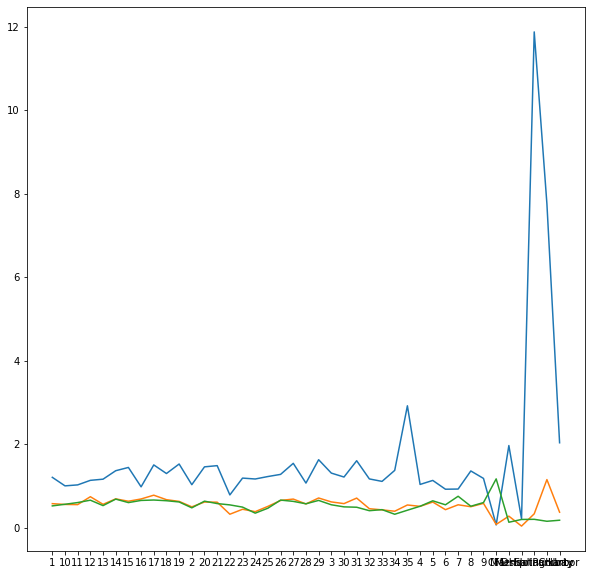

In [100]:
smry=df2.groupby('Grid').mean()

figure(figsize=(10,10))
plt.plot(smry[algae])



smry.sort_values(by=algae[1],ascending=False)




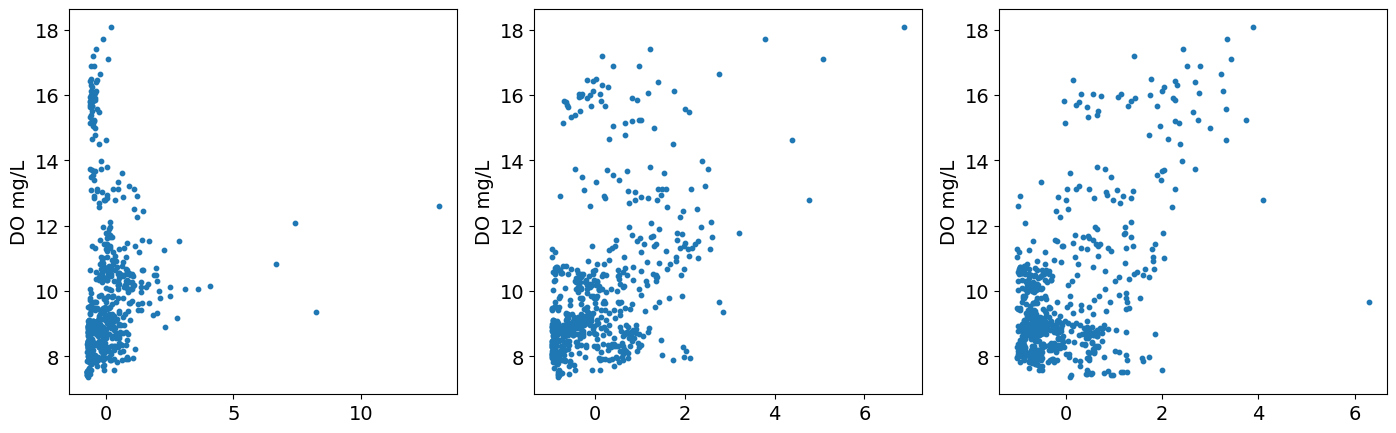

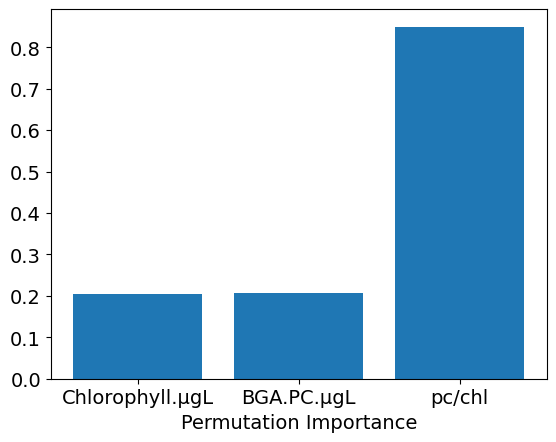

Rsquare ANN RS 0.35881062005299946
Rsquare RF RS 0.468125708154317


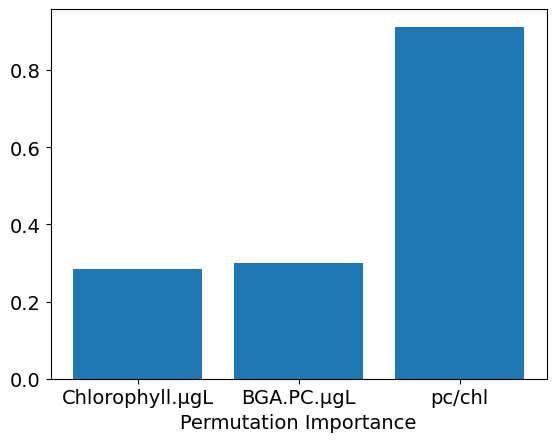

Rsquare ANN RS 0.44418757636783723
Rsquare RF RS 0.5353032019706234


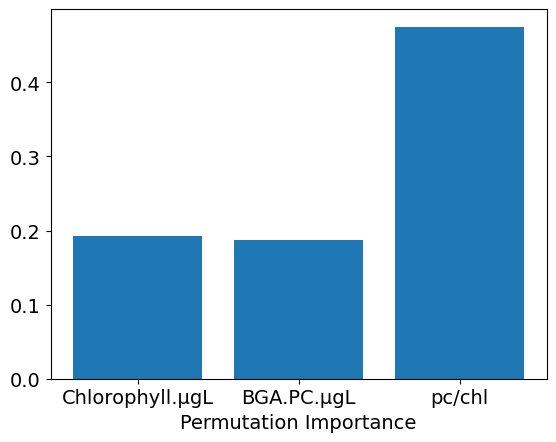

Rsquare ANN RS 0.39337480325516005
Rsquare RF RS 0.5189315458431663


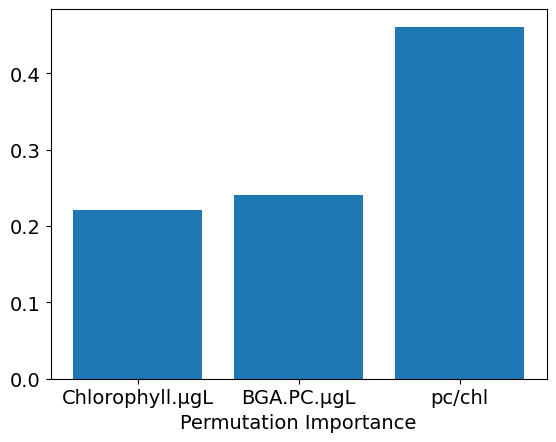

Rsquare ANN RS 0.46793241339242886
Rsquare RF RS 0.5394630288406224


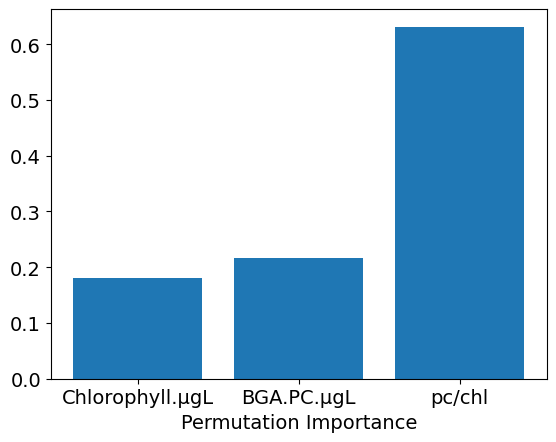

Rsquare ANN RS 0.4062830216959681
Rsquare RF RS 0.46788809535972997
Fold Average Pearson R ANN [0.3487888642511195]
Fold Average R-square ANN 0.4092095914834607
Fold Average MAE ANN 1.0419517702016101
Fold Average Pearson R RF 0.37225272190370695
Fold Average R-square RF 0.5391056694141783
Fold Average MAE RF 0.9208794991614406


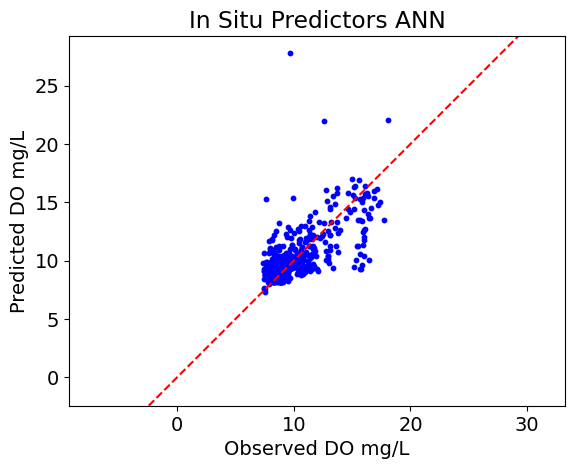

Pearson r explanatory model (array([0.69125533], dtype=float32), 3.22463498009386e-93)
Rsquare 0.4175984059981489


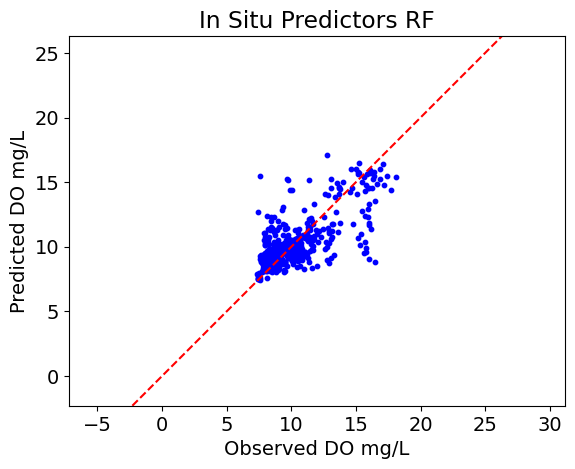

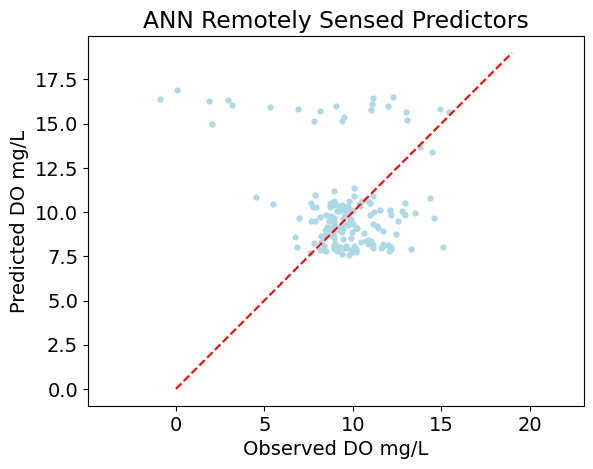

Pearson r explanatory model (-0.20820357385619637, 0.008041276544285242)
Rsquare -1.4165102476037261
MAE 2.3855145097636403


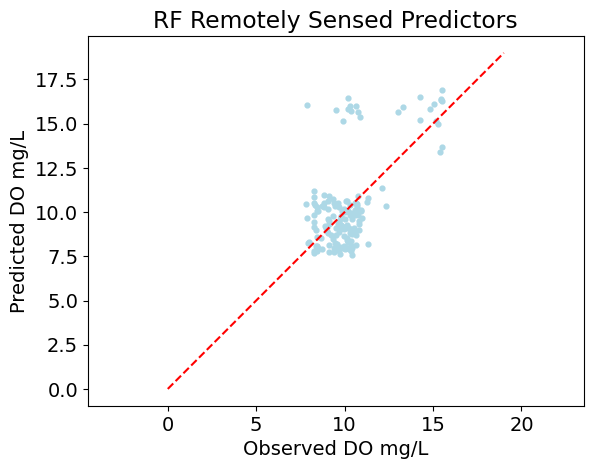

Pearson r explanatory model (0.6285667256191793, 4.387689330787844e-19)
Rsquare 0.3912394831741154
MAE 1.3902734355009563


In [18]:
import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance


algae=['Chlorophyll.µgL','BGA.PC.µgL','pc/chl']


df2=df2[(df2['Chlorophyll.µgL']>=0) & (df2['BGA.PC.µgL']>=0)]
df2['pc/chl']=df2['BGA.PC.µgL']/df2['Chlorophyll.µgL']

df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df2=df2.dropna(subset=['pc/chl'])

odo = s3_wide['ODO.mg.L']

Y=df2['ODO.mg.L']

scaler = StandardScaler()
scaler.fit(df2[algae])
Xsc=scaler.transform(df2[algae])

Xsc = pd.DataFrame(Xsc)
Xsc.columns = algae



doANN = []
prANN=[]
maeANN=[]

doRF = []
prRF=[]
maeRF=[]

fimp=[]


algae_preds=pd.DataFrame(rf_predout)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,5), sharey=False)
for i,ax in enumerate(axes):
    ax.scatter(Xsc.iloc[:,i],Y,s=10)
    ax.set_ylabel('DO mg/L')
plt.show()



predsANN_DO=pd.DataFrame({'test' : [],'pred' : []})
predsRF_DO=pd.DataFrame({'test' : [],'pred' : []})

#Cross Validation
random_state = 42
rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=random_state)
for j,(train, test) in enumerate(rkf.split(Xsc)):

    X_train, X_test, Y_train, Y_test = Xsc.iloc[train], Xsc.iloc[test], Y.iloc[train], Y.iloc[test]


    #ANN models
    input_dim = X_train.shape[1]
    num_classes = 1

    #final model
    model = Sequential()
    model.add(Dense(128, input_dim=len(algae), kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train.values.ravel(), epochs=500, verbose=0, batch_size=20)


    #In situ Data
    y_pred = model.predict(X_test)
    foldResults_ANN=pd.DataFrame(zip(Y_test,y_pred), columns = ['test','pred'])
    predsANN_DO=pd.concat([predsANN_DO,foldResults_ANN],axis=0)

    fold.append([j]*len(X_test))
    prANN.append(pearsonr(Y_test,y_pred))
    doANN.append(r2_score(Y_test,y_pred))
    maeANN.append(mean_absolute_error(Y_test,y_pred))

    
    rfr = RandomForestRegressor(n_estimators = 1000)
    rfr.fit(X_train, Y_train.values.ravel())
    y_pred = rfr.predict(X_test)
    
    #Feature importance
    perm_importance = permutation_importance(rfr, X_test, Y_test)
    sorted_idx = perm_importance.importances_mean.argsort()
    fimp.append(perm_importance.importances_mean)
    plt.bar(algae, perm_importance.importances_mean)
    plt.xlabel("Permutation Importance")
    plt.show()
    
    prRF.append(pearsonr(Y_test,y_pred))
    doRF.append(r2_score(Y_test,y_pred))
    maeRF.append(mean_absolute_error(Y_test,y_pred))
    foldResults_RF=pd.DataFrame(zip(Y_test,y_pred), columns = ['test','pred'])
    predsRF_DO=pd.concat([predsRF_DO,foldResults_RF],axis=0)
    
    
    test=pd.DataFrame(scaler.transform(algae_preds))
    test.columns = algae_preds.columns
    #RS data
    odopred_rs = model.predict(test)
    print('Rsquare ANN RS',r2_score(odo_cv_rf,odopred_rs))
    odopred_rs = rfr.predict(test)
    print('Rsquare RF RS',r2_score(odo_cv_rf,odopred_rs ))
    
    

    

print('Fold Average Pearson R ANN',np.mean(prANN)) #r, p
print('Fold Average R-square ANN',np.mean(doANN))
print('Fold Average MAE ANN',np.mean(maeANN))
    
print('Fold Average Pearson R RF',np.mean(prRF)) #r, p
print('Fold Average R-square RF',np.mean(doRF))
print('Fold Average MAE RF',np.mean(maeRF))  



plt.axline((-1,-1),(25,25),linestyle='--',color='red')
plt.scatter(predsANN_DO['test'],predsANN_DO['pred'], color="blue",s=10)
plt.xlabel('Observed DO mg/L')
plt.ylabel('Predicted DO mg/L')
plt.axis('equal')
plt.title('In Situ Predictors ANN')

plt.show()
print('Pearson r explanatory model',scipy.stats.pearsonr(predsANN_DO['test'],predsANN_DO['pred']))
print('Rsquare',r2_score(predsANN_DO['test'],predsANN_DO['pred']))


plt.axline((-1,-1),(25,25),linestyle='--',color='red')
plt.scatter(predsRF_DO['test'],predsRF_DO['pred'], color="blue",s=10)
plt.xlabel('Observed DO mg/L')
plt.ylabel('Predicted DO mg/L')
plt.axis('equal')
plt.title('In Situ Predictors RF')

plt.show()






#Remotely Sensed

predout=algaePreds[['Chlorophyll.µgL_p','BGA.PC.µgL_p','pc/chl_p']]

scaler = StandardScaler()
scaler.fit(pd.DataFrame(predout))
algae_preds=scaler.transform(pd.DataFrame(predout))

#Sort odo by grid num
odoObs=pd.concat((odo_cv_rf,grid_cv_rf),axis=1)
odoObs.sort_values(by='Grid',inplace=True)


odopred_rs = model.predict(algae_preds)

xy_line = range(0,20)
plt.plot(xy_line, 'r--')
plt.scatter(odopred_rs.squeeze(),odoObs['ODO.mg.L'], color="lightblue",s=12)
plt.xlabel('Observed DO mg/L')
plt.ylabel('Predicted DO mg/L')
plt.axis('equal')
plt.title('ANN Remotely Sensed Predictors')
plt.show()
print('Pearson r explanatory model',scipy.stats.pearsonr(odopred_rs.squeeze(),odoObs['ODO.mg.L']))
print('Rsquare',r2_score(odoObs['ODO.mg.L'],odopred_rs))
print('MAE',mean_absolute_error(odoObs['ODO.mg.L'],odopred_rs))

odopred_rs = rfr.predict(algae_preds)

xy_line = range(0,20)
plt.plot(xy_line, 'r--')
plt.scatter(odopred_rs,odoObs['ODO.mg.L'], color="lightblue",s=12)
plt.xlabel('Observed DO mg/L')
plt.ylabel('Predicted DO mg/L')
plt.axis('equal')
plt.title('RF Remotely Sensed Predictors')
plt.show()
print('Pearson r explanatory model',scipy.stats.pearsonr(odopred_rs.squeeze() ,odoObs['ODO.mg.L']))
print('Rsquare',r2_score(odoObs['ODO.mg.L'],odopred_rs))
print('MAE',mean_absolute_error(odoObs['ODO.mg.L'],odopred_rs))



#Combine predictions and observations, sorted by Grid (above) and add them onto the algaePreds df
odoPred=pd.DataFrame(odopred_rs)
odoPred.reset_index(drop=True,inplace=True)
odoObs.reset_index(drop=True,inplace=True)
odoOut=pd.concat((odoObs['ODO.mg.L'],odoPred,odoObs['Grid']),axis=1,ignore_index=True)


odoOut.columns = ['odo_o','odo_p','grid']




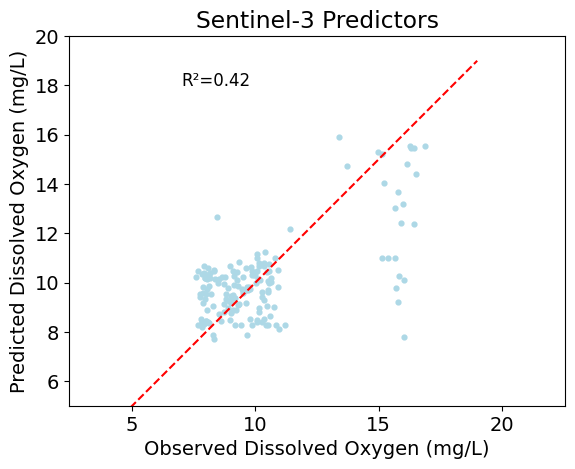

Pearson r explanatory model (0.10958670120661464, 0.1664085873657374)
Rsquare 0.4231262047597628


In [14]:
plt.rcParams["font.size"] = 14
xy_line = range(0,20)
plt.plot(xy_line, 'r--')
plt.scatter(odoObs['ODO.mg.L'],odopred_rs, color="lightblue",s=12)
plt.xlabel('Observed Dissolved Oxygen (mg/L)')
plt.ylabel('Predicted Dissolved Oxygen (mg/L)')
plt.text(7, 18, 'R²=%s' % round(r2_score(odoObs['ODO.mg.L'],odopred_rs),2), fontsize=12)
plt.axis('equal')
plt.title('Sentinel-3 Predictors')
plt.xlim([5,20])
plt.ylim([5,20])
plt.show()
print('Pearson r explanatory model',scipy.stats.pearsonr(odopred_rs.squeeze() ,odo))
print('Rsquare',r2_score(odoObs['ODO.mg.L'],odopred_rs))

s3odo_rf= pd.DataFrame(zip(odoObs['ODO.mg.L'],odopred_rs),columns=["ODO_obs","ODO_pred"])

#s3odo_rf.to_csv("~/Desktop/S3ODO_RF.csv")

Feature importance DO model

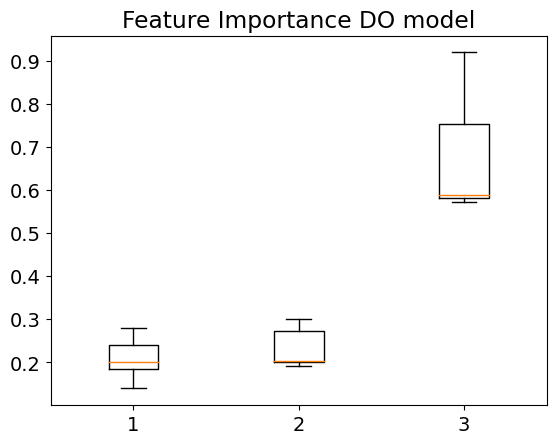

0.20925022817885736
0.23331690452002193
0.6830037560871134


[array([0.20188758, 0.20017521, 0.75425566]),
 array([0.28050003, 0.300398  , 0.91907738]),
 array([0.23969211, 0.20251377, 0.57120509]),
 array([0.13944139, 0.27297377, 0.58108185]),
 array([0.18473004, 0.19052377, 0.58939881])]

In [15]:


plt.boxplot(np.asarray(fimp))
plt.title("Feature Importance DO model")
plt.show()


print(np.asarray(fimp)[:,0].mean())
print(np.asarray(fimp)[:,1].mean())
print(np.asarray(fimp)[:,2].mean())
fimp


## Investigate Errors

float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64


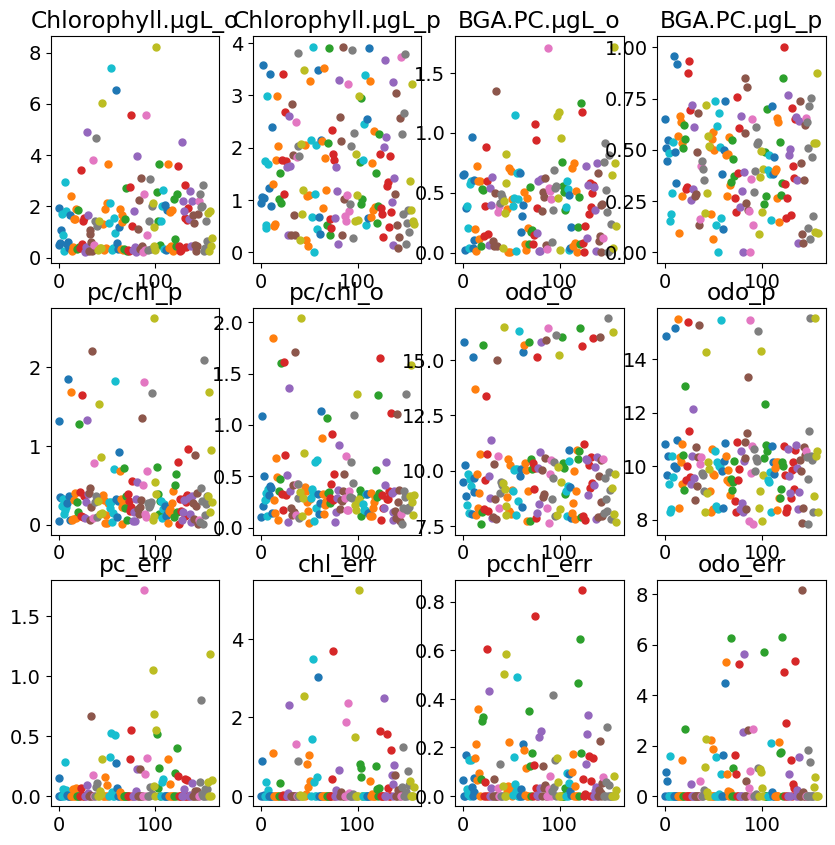

Chlorophyll.µgL_o    float64
Chlorophyll.µgL_p    float64
grid                 float64
BGA.PC.µgL_o         float64
BGA.PC.µgL_p         float64
                      ...   
odo_p                float64
pc_err               float64
chl_err              float64
pcchl_err            float64
odo_err              float64
Length: 13, dtype: object

In [19]:
obs_preds_all=pd.concat((algaePreds,odoOut),axis=1)



gridshp = gpd.read_file("/Users/maxbeal/Desktop/PhD/Sampling/Mendota Shapefiles/Mendotaboundary_gridnums.shp")
gridshp = gridshp.to_crs("EPSG:4326")
grid = s3_wide['Grid']




obs_preds_all=pd.concat((algaePreds,odoOut),axis=1)

obs_preds_all=obs_preds_all.loc[:,~obs_preds_all.columns.duplicated()].copy()

obs_preds_all=obs_preds_all[obs_preds_all['grid']!='DH']





#Calculate Errors
obs_preds_all['pc_err'] = obs_preds_all['BGA.PC.µgL_o'] - obs_preds_all['BGA.PC.µgL_p']
obs_preds_all['chl_err'] = obs_preds_all['Chlorophyll.µgL_o'] - obs_preds_all['Chlorophyll.µgL_p']
obs_preds_all['pcchl_err'] = obs_preds_all['pc/chl_o'] - obs_preds_all['pc/chl_p']
obs_preds_all['odo_err'] = obs_preds_all['odo_o'] - obs_preds_all['odo_p']

#set values less than zero to zero
num_names = ['BGA.PC.µgL_p','Chlorophyll.µgL_p','pc/chl_p','odo_p','grid','BGA.PC.µgL_o','Chlorophyll.µgL_o','pc/chl_o','odo_o','pc_err','chl_err','pcchl_err','odo_err']
for name in num_names:
    obs_preds_all[name] = obs_preds_all[name].astype(float)
    
    obs_preds_all[name] = pd.to_numeric(obs_preds_all[name])
    obs_preds_all.loc[obs_preds_all[name] < 0, name] = 0
    
    print(obs_preds_all[name].dtypes)
   

#Line plots
nrows = 3
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10), sharey=False)
plotnames = obs_preds_all.columns
plotnames = plotnames[plotnames!="grid"]
for i, ax in enumerate(axes.flatten()):
    grouped = obs_preds_all.groupby('grid')[plotnames[i]].plot(legend=False,ax=ax, marker='o', linestyle='none', markersize=5)
    ax.set_title(plotnames[i])
    
plt.show()

obs_preds_all.dtypes

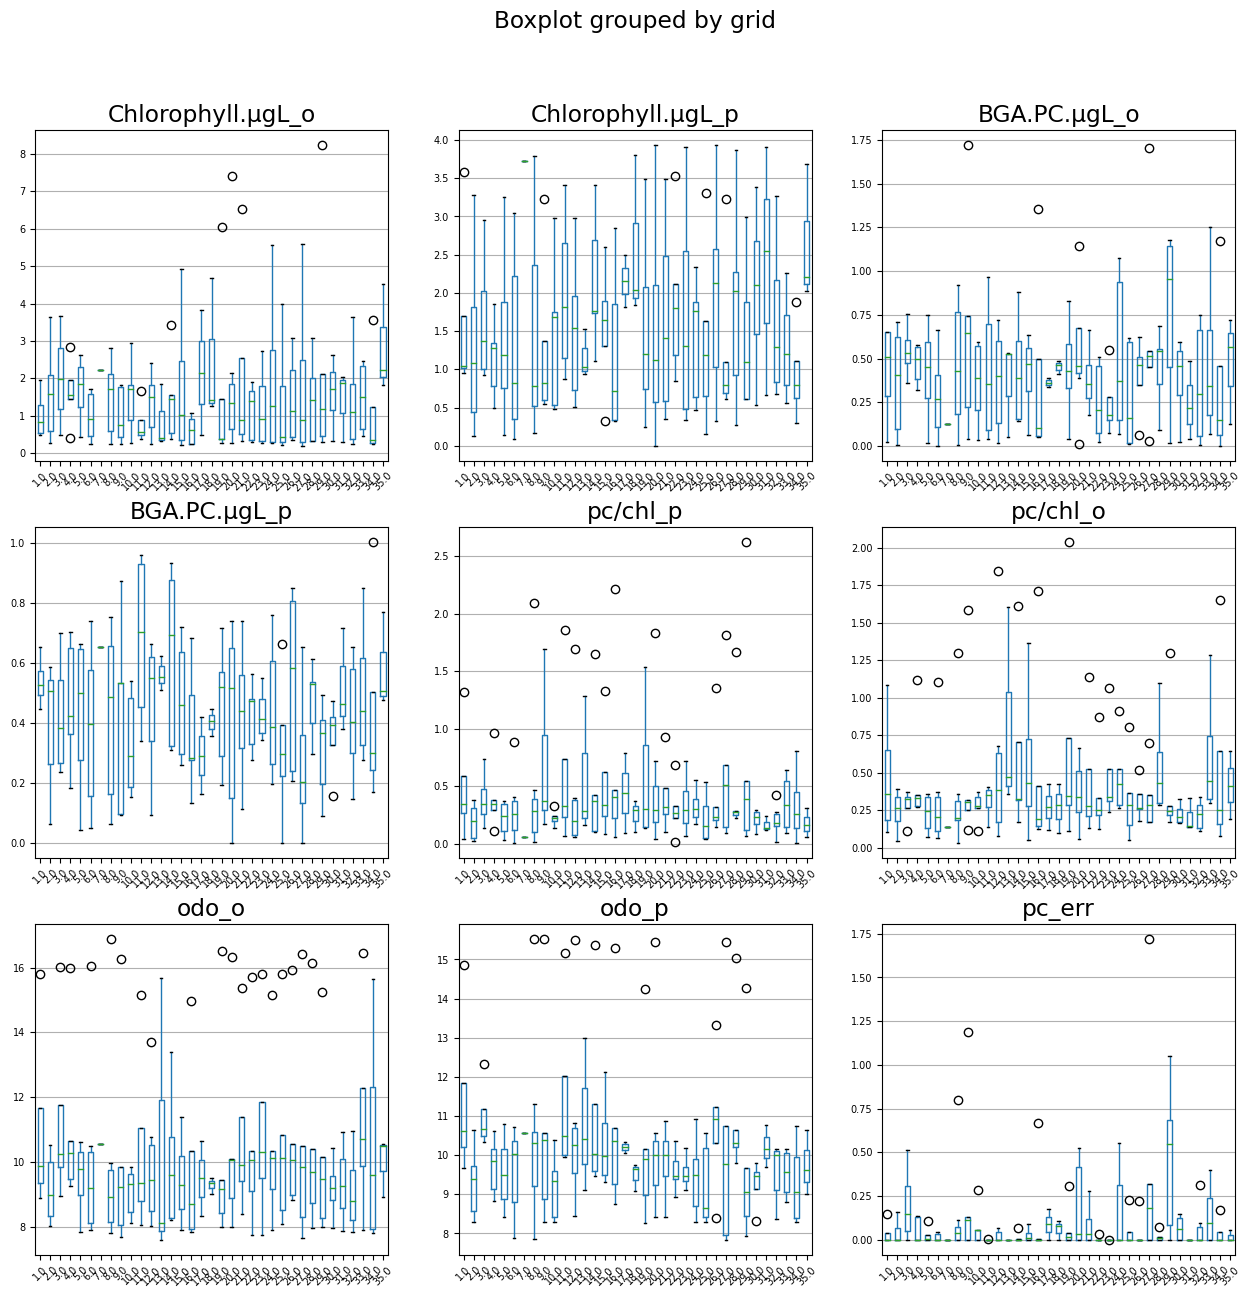

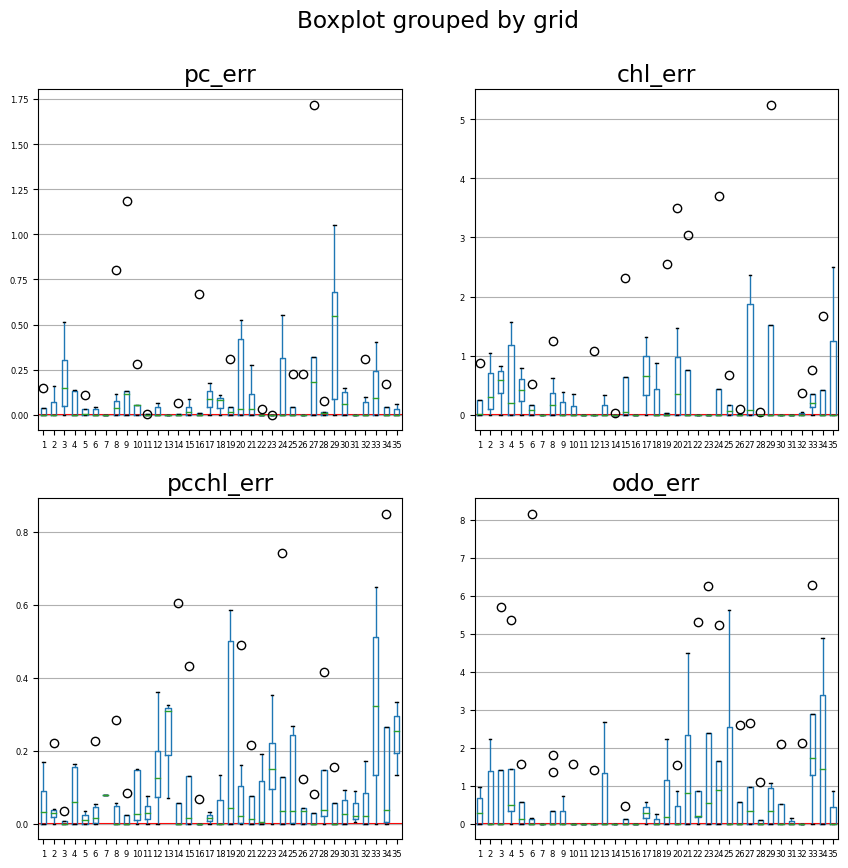

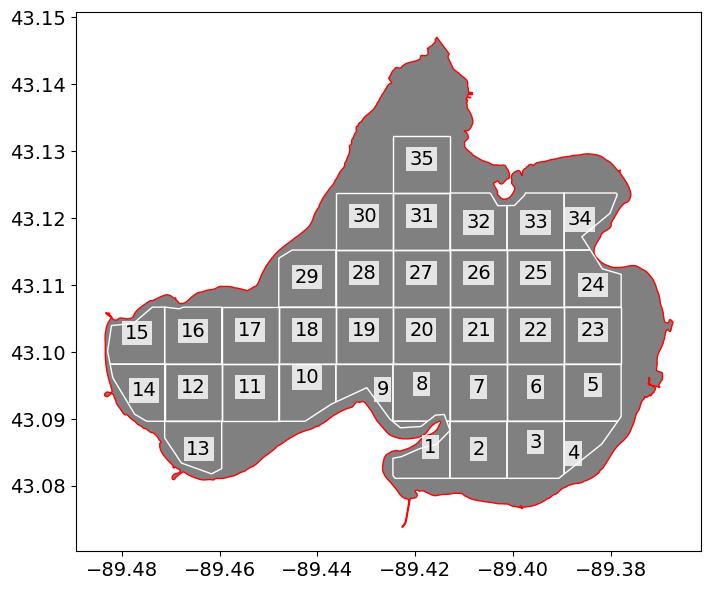

In [20]:
grid_nums = pd.to_numeric(pd.unique(obs_preds_all['grid']),downcast='integer')
grid_nums = grid_nums[~np.isnan(grid_nums)]
grid_nums.sort()


obs_preds_all['grid'] = pd.to_numeric(obs_preds_all['grid'])



#Whisker plots all
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15), sharey=False)
plotnames = obs_preds_all.columns
plotnames = plotnames[plotnames!="grid"]
for i, ax in enumerate(axes.flatten()):
    obs_preds_all.boxplot(column=[plotnames[i]], by='grid', ax=ax,fontsize=7,rot=45)
    ax.set_xlabel("")
    ax.xaxis.grid(False)
plt.show()




#Whisker plots error
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10), sharey=False)
plotnames = obs_preds_all.columns
plotnames = plotnames[plotnames!="grid"]

for i, ax in enumerate(axes.flatten()):
        obs_preds_all.boxplot(column=[plotnames[i+8]], by='grid', ax=ax,fontsize=6,rot=0)
        ax.axhline(y=0, color='r', linestyle='-',zorder=0)
        ax.xaxis.grid(False)
        ax.set_xlabel("")
        ax.set_xticklabels(grid_nums.astype(int))


        
gridshp = gridshp[gridshp['ID']!="DH"] #Remove DH
#Representative point returns a cheaply computed point that is guaranteed to be within the geometric object. Good for labels.
gridshp['coords'] = gridshp['geometry'].apply(lambda x: x.representative_point().coords[:])
gridshp['coords'] = [coords[0] for coords in gridshp['coords']]
    
plt.show()

fig, ax = plt.subplots(figsize=(10,7))
mendota.plot(ax=ax,edgecolor="r",facecolor="gray")
gridshp.plot(ax=ax,edgecolor='white',facecolor="none")
for idx, row in gridshp.iterrows():
    plt.annotate(text=row['ID'], xy=row['coords'],
                 horizontalalignment='center', 
                 bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})



Format Grids

In [21]:
gridshp["ID"] = pd.to_numeric(gridshp["ID"])
gridshp = gridshp.sort_values(by=["ID"],ignore_index=True)
geom = gridshp['geometry']

gridshp2=gridshp.merge(obs_preds_all, left_on='ID', right_on='grid')

gridshp_grouped = gridshp2.groupby(['grid'])

gridshp_f = gridshp2.groupby(['grid']).mean()
gridshp_f.reset_index(inplace=True)
gridshp_f['geometry'] = geom


from sklearn.metrics import mean_squared_error
obsnames = ['BGA.PC.µgL_o', 'Chlorophyll.µgL_o', 'pc/chl_o', 'odo_o',]
prednames = ['BGA.PC.µgL_p', 'Chlorophyll.µgL_p', 'pc/chl_p', 'odo_p',]
outnames = ['mae_pc', 'mae_chl', 'mae_pcchl','mae_odo']

store=pd.DataFrame(columns=outnames)

for i, name in enumerate(obsnames):
    mae_by_id = gridshp_grouped[obsnames[i], prednames[i]].apply(lambda x: np.mean(np.abs(x[obsnames[i]] - x[prednames[i]])))
    store[outnames[i]] = mae_by_id


store.reset_index(inplace=True,drop=True)

for i in outnames:
    gridshp_f[i] = store[i]
    
gridshp_f



,grid,left,top,right,bottom,...,geometry,mae_pc,mae_chl,mae_pcchl,mae_odo
0,1.0,-89.424566,43.089619,-89.412888,43.081090,...,"MULTIPOLYGON (((-89.42416 43.08109, -89.42457 ...",0.185924,1.095671,0.150126,1.097525
1,2.0,-89.412888,43.089619,-89.401210,43.081090,...,"POLYGON ((-89.41289 43.08824, -89.41287 43.088...",0.115809,0.545266,0.055982,1.514575
2,3.0,-89.401210,43.089619,-89.389531,43.081090,...,"POLYGON ((-89.38953 43.08172, -89.39062 43.081...",0.289409,0.636151,0.124727,2.487848
3,4.0,-89.389531,43.089619,-89.377853,43.081090,...,"POLYGON ((-89.37854 43.08962, -89.38182 43.086...",0.103014,0.686625,0.097009,1.641562
4,5.0,-89.389531,43.098147,-89.377853,43.089619,...,"POLYGON ((-89.37785 43.09033, -89.37854 43.089...",0.064130,0.563470,0.017456,0.961176
...,...,...,...,...,...,...,...,...,...,...,...
30,31.0,-89.424566,43.123723,-89.412888,43.115199,...,"POLYGON ((-89.42457 43.12372, -89.41289 43.123...",0.272856,0.967644,0.039706,0.969900
31,32.0,-89.412888,43.123723,-89.401210,43.115199,...,"POLYGON ((-89.40464 43.12372, -89.40312 43.121...",0.202347,0.363971,0.092128,1.210744
32,33.0,-89.401210,43.123723,-89.389531,43.115199,...,"POLYGON ((-89.40121 43.12184, -89.39969 43.121...",0.296041,0.392223,0.373885,2.968283
33,34.0,-89.389531,43.123723,-89.377853,43.115199,...,"POLYGON ((-89.37881 43.12372, -89.37866 43.123...",0.159511,0.648755,0.235542,2.542351


cmap

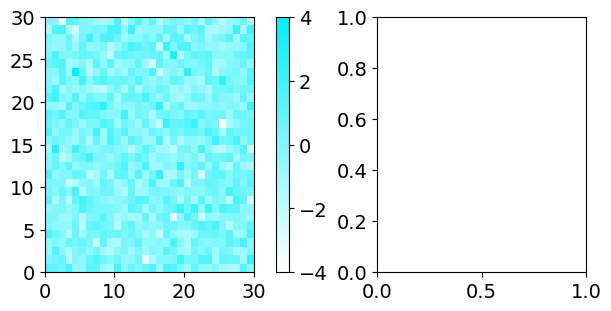

In [22]:
#Create colormap

from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap


def plot_examples(cms):
    """
    helper function to plot two colormaps
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()
    

# create cyan colormaps
N = 256
cyan = np.ones((N, 4))
cyan[:, 0] = np.linspace(0/256, 1, N) # R = 255
cyan[:, 1] = np.linspace(240/256, 1, N) # G = 232
cyan[:, 2] = np.linspace(250/256, 1, N)  # B = 11
cyan_cmp = ListedColormap(cyan,name='cyan')
cyan_cmp=cyan_cmp.reversed()


plot_examples([cyan_cmp])

Plot Errors by grid

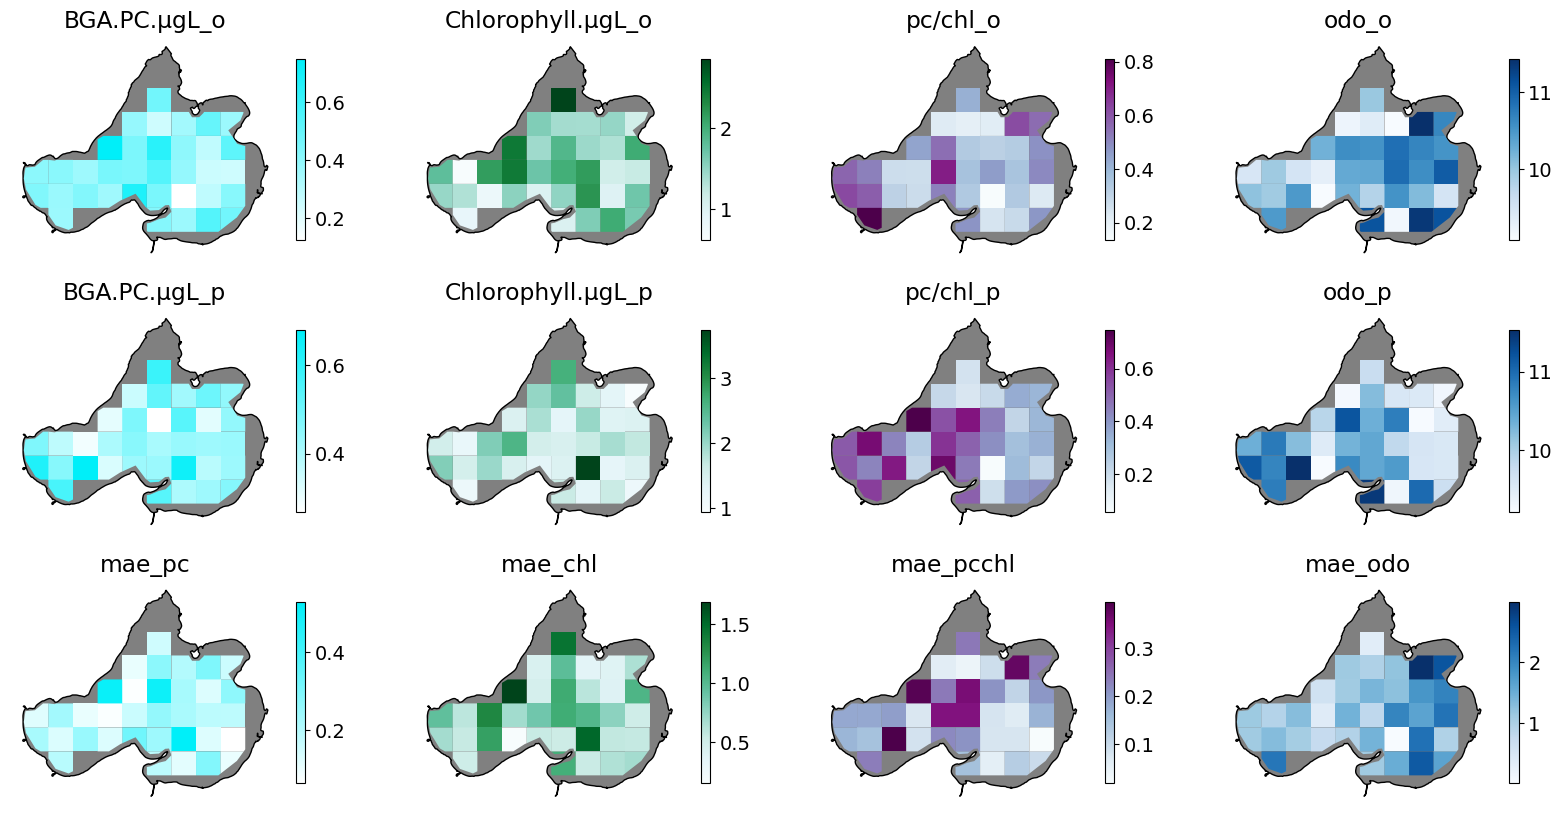

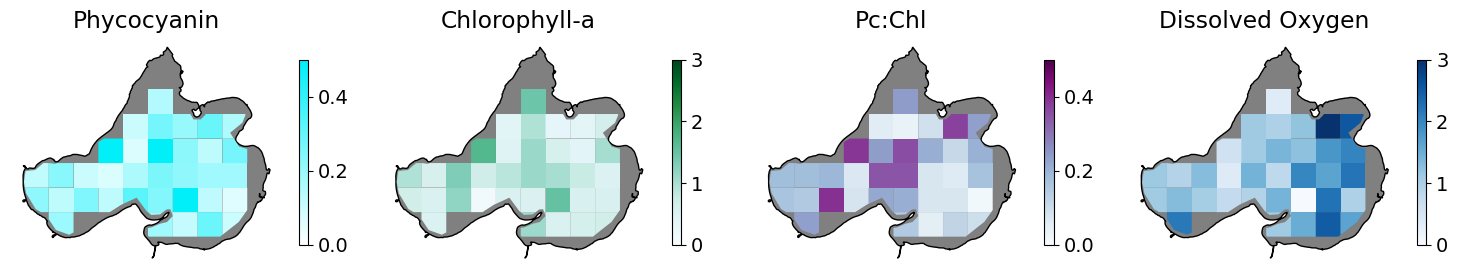

In [23]:
#cmap='coolwarm'
#cmap='winter'
gridshp.columns
# Suppress/hide the warning
np.seterr(invalid='ignore')

colormaps = [cyan_cmp,'BuGn','BuPu','Blues'] + [cyan_cmp,'BuGn','BuPu','Blues'] + [cyan_cmp,'BuGn','BuPu','Blues']

#Whisker plots error
nrows = 3
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10), sharey=False)
plotnames_merr = ['pc_err','chl_err', 'pcchl_err', 'odo_err']
plotnames_mae = ['mae_pc', 'mae_chl', 'mae_pcchl','mae_odo']
plotnames_o = ['BGA.PC.µgL_o', 'Chlorophyll.µgL_o', 'pc/chl_o', 'odo_o',]
plotnames_p = ['BGA.PC.µgL_p', 'Chlorophyll.µgL_p', 'pc/chl_p', 'odo_p',]

plotnames = plotnames_o + plotnames_p + plotnames_mae

for i, ax in enumerate(axes.flatten()):
    mendota.plot(ax=ax,edgecolor="black",facecolor="gray")
    gridshp_f.plot(column = plotnames[i],ax=ax,legend=True,cmap=colormaps[i],legend_kwds={'shrink': 0.8})
    ax.set_title(plotnames[i])
    ax.set_aspect('auto')
    ax.set_axis_off()
plt.show()





#Map plot error
plotnames_mae = ['mae_pc', 'mae_chl', 'mae_pcchl','mae_odo']
labels_mae = ['Phycocyanin', 'Chlorophyll-a', 'Pc:Chl','Dissolved Oxygen']
cbmax = [0.5,3,0.5,3]
nrows = 1
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,3), sharey=False)

for i, ax in enumerate(axes.flatten()):
    mendota.plot(ax=ax,edgecolor="black",facecolor="gray")
    gridshp_f.plot(column = plotnames_mae[i],ax=ax,legend=True,cmap=colormaps[i],legend_kwds={'shrink': 0.8},vmax=cbmax[i],vmin=0)
    ax.set_title(labels_mae[i])
    ax.set_aspect('auto')
    ax.set_axis_off()
fig.tight_layout()
plt.show()


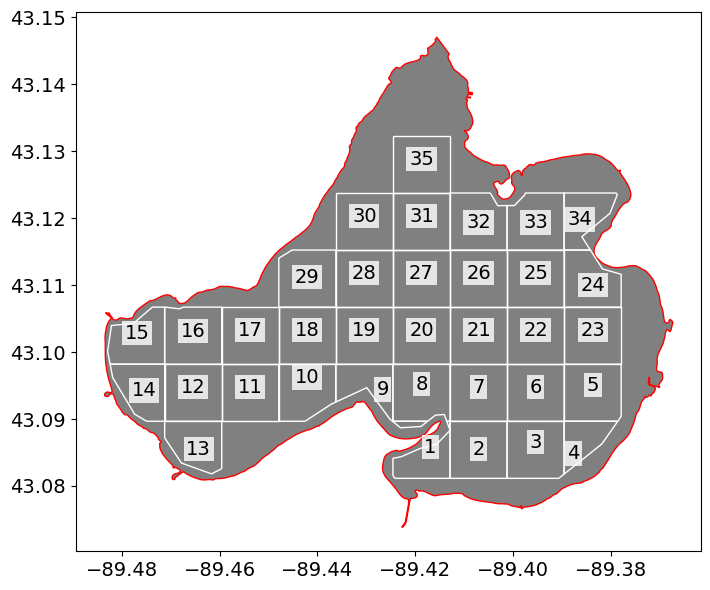

2.2189454217165094
32    2.968283
33    2.542351
2     2.487848
5     2.228259
22    2.204975
        ...   
9     0.763382
28    0.603394
17    0.381225
34    0.351845
6     0.020567
Name: mae_odo, Length: 35, dtype: float64


,grid,left,top,right,bottom,...,geometry,mae_pc,mae_chl,mae_pcchl,mae_odo
0,1.0,-89.424566,43.089619,-89.412888,43.081090,...,"MULTIPOLYGON (((-89.42416 43.08109, -89.42457 ...",0.185924,1.095671,0.150126,1.097525
1,2.0,-89.412888,43.089619,-89.401210,43.081090,...,"POLYGON ((-89.41289 43.08824, -89.41287 43.088...",0.115809,0.545266,0.055982,1.514575
2,3.0,-89.401210,43.089619,-89.389531,43.081090,...,"POLYGON ((-89.38953 43.08172, -89.39062 43.081...",0.289409,0.636151,0.124727,2.487848
3,4.0,-89.389531,43.089619,-89.377853,43.081090,...,"POLYGON ((-89.37854 43.08962, -89.38182 43.086...",0.103014,0.686625,0.097009,1.641562
4,5.0,-89.389531,43.098147,-89.377853,43.089619,...,"POLYGON ((-89.37785 43.09033, -89.37854 43.089...",0.064130,0.563470,0.017456,0.961176
...,...,...,...,...,...,...,...,...,...,...,...
30,31.0,-89.424566,43.123723,-89.412888,43.115199,...,"POLYGON ((-89.42457 43.12372, -89.41289 43.123...",0.272856,0.967644,0.039706,0.969900
31,32.0,-89.412888,43.123723,-89.401210,43.115199,...,"POLYGON ((-89.40464 43.12372, -89.40312 43.121...",0.202347,0.363971,0.092128,1.210744
32,33.0,-89.401210,43.123723,-89.389531,43.115199,...,"POLYGON ((-89.40121 43.12184, -89.39969 43.121...",0.296041,0.392223,0.373885,2.968283
33,34.0,-89.389531,43.123723,-89.377853,43.115199,...,"POLYGON ((-89.37881 43.12372, -89.37866 43.123...",0.159511,0.648755,0.235542,2.542351


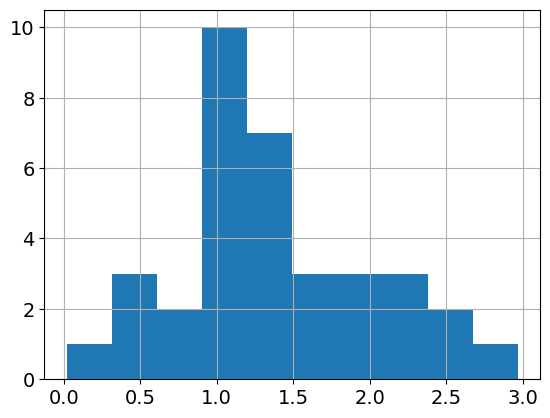

In [24]:


fig, ax = plt.subplots(figsize=(10,7))
mendota.plot(ax=ax,edgecolor="r",facecolor="gray")
gridshp.plot(ax=ax,edgecolor='white',facecolor="none")
for idx, row in gridshp.iterrows():
    plt.annotate(text=row['ID'], xy=row['coords'],
                 horizontalalignment='center', 
                 bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})
  
plt.show()
gridshp_f['mae_odo'].hist()
    

print(gridshp_f['mae_odo'].quantile(.9))

print(gridshp_f['mae_odo'].sort_values(ascending=False))

gridshp_f



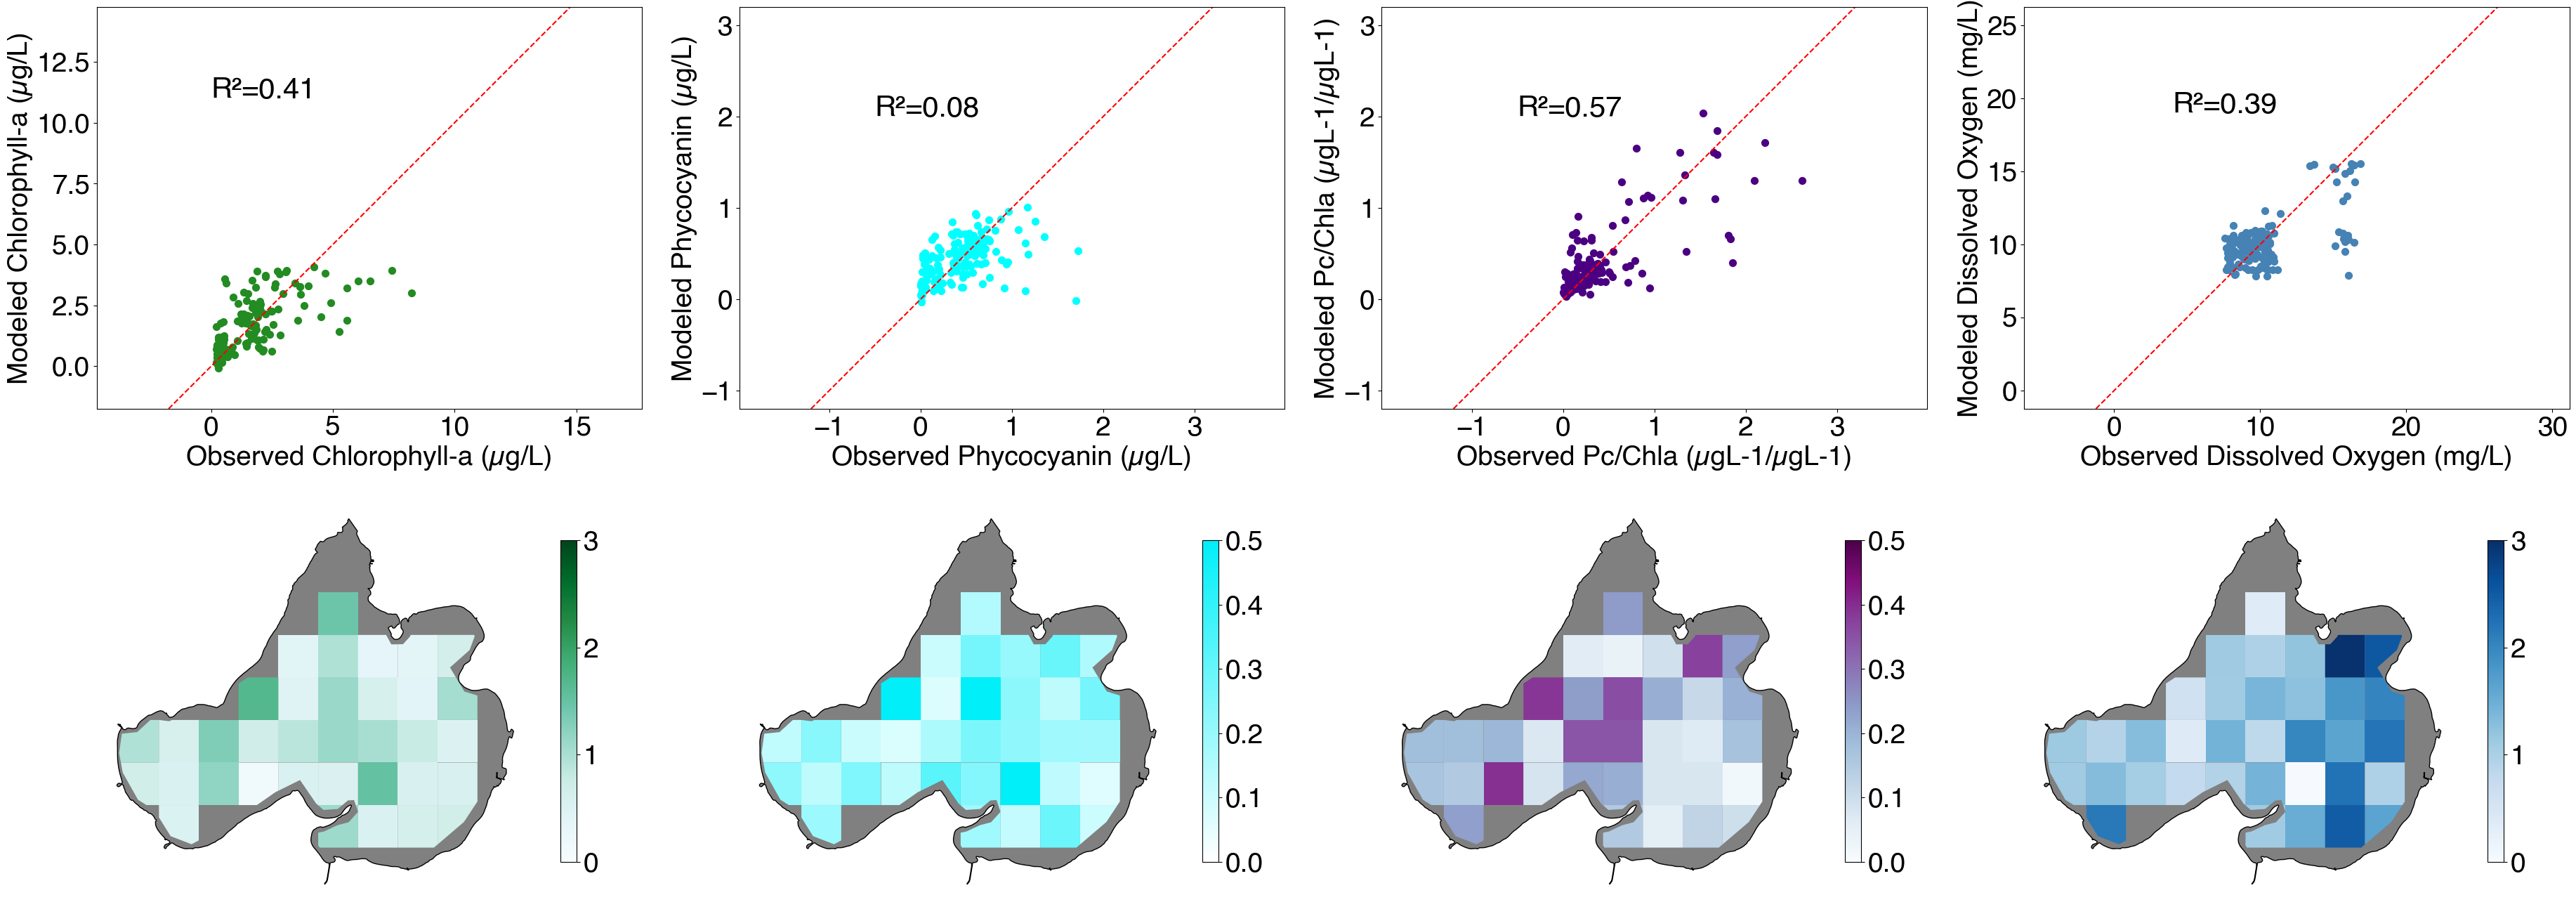

In [27]:


# Styling
plt.style.use("default")
plt.rcParams["font.family"] = "helvetica"
plt.rcParams["font.size"] = 28

font = 30
psize = 50

# Create Blank Figure
fig = plt.figure(figsize=(37, 14))
# Create Grid
gs = fig.add_gridspec(nrows=2, ncols=4)

# Create Three Axes Objects
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])


# Plot Data
xy_line = range(0,14)
ax1.scatter(ann_testout['Chlorophyll.µgL'],ann_predout['Chlorophyll.µgL'], color="forestgreen", linewidth=1,s=psize)
ax1.axline((-1,-1),(14,14), linestyle='--',color='red')
ax1.set_xlabel('Observed Chlorophyll-a (µg/L)')
ax1.set_ylabel('Modeled Chlorophyll-a (µg/L)')
ax1.axis('equal')
ax1.text(0, 11, 'R²=%s' % round(r2_score(rf_testout['Chlorophyll.µgL'],rf_predout['Chlorophyll.µgL']),2), fontsize=font)


xy_line = range(0,4)
ax2.scatter(ann_testout['BGA.PC.µgL'],ann_predout['BGA.PC.µgL'], color="cyan", linewidth=1,s=psize)
ax2.axline((-1,-1),(3,3), linestyle='--',color='red')
ax2.set_xlabel('Observed Phycocyanin (µg/L)')
ax2.set_ylabel('Modeled Phycocyanin (µg/L)')
ax2.axis('equal')
ax2.text(-0.5, 2, 'R²=%s' % round(r2_score(rf_testout['BGA.PC.µgL'],rf_predout['BGA.PC.µgL']),2), fontsize=font)



xy_line = range(0,4)
ax3.scatter(rf_testout['pc/chl'],rf_predout['pc/chl'], color="indigo",s=psize)
ax3.axline((-1,-1),(3,3), linestyle='--',color='red')
ax3.set_xlabel('Observed Pc/Chla (µgL-1/µgL-1)')
ax3.set_ylabel('Modeled Pc/Chla (µgL-1/µgL-1)')
ax3.axis('equal')
ax3.text(-0.5, 2, 'R²=%s' % round(r2_score(rf_testout['pc/chl'],rf_predout['pc/chl']),2), fontsize=font)


ax4.axline((0,0),(25,25),linestyle='--',color='red')
ax4.scatter(odoObs['ODO.mg.L'],odopred_rs, color="steelblue", s=psize)
ax4.set_xlabel('Observed Dissolved Oxygen (mg/L)')
ax4.set_ylabel('Modeled Dissolved Oxygen (mg/L)')
ax4.axis('equal')
ax4.text(4, 19, 'R²=%s' % round(r2_score(odoObs['ODO.mg.L'],odopred_rs),2), fontsize=font)



# Create Next Three Axes Objects
ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[1, 2])
ax8 = fig.add_subplot(gs[1, 3])


plotnames_mae = ['mae_chl','mae_pc', 'mae_pcchl','mae_odo']
labels_mae = ['Chlorophyll-a','Phycocyanin', 'Pc:Chl','Dissolved Oxygen']
cbmax = [3,0.5,0.5,3]

mendota.plot(ax=ax5,edgecolor="black",facecolor="gray")
gridshp_f.plot(column = plotnames_mae[0],ax=ax5,legend=True,cmap=colormaps[1],legend_kwds={'shrink': 0.8},vmax=cbmax[0],vmin=0)
ax5.set_aspect('auto')
ax5.set_axis_off()

mendota.plot(ax=ax6,edgecolor="black",facecolor="gray")
gridshp_f.plot(column = plotnames_mae[1],ax=ax6,legend=True,cmap=colormaps[0],legend_kwds={'shrink': 0.8},vmax=cbmax[1],vmin=0)
ax6.set_aspect('auto')
ax6.set_axis_off()

mendota.plot(ax=ax7,edgecolor="black",facecolor="gray")
gridshp_f.plot(column = plotnames_mae[2],ax=ax7,legend=True,cmap=colormaps[2],legend_kwds={'shrink': 0.8},vmax=cbmax[2],vmin=0)
ax7.set_aspect('auto')
ax7.set_axis_off()

mendota.plot(ax=ax8,edgecolor="black",facecolor="gray")
gridshp_f.plot(column = plotnames_mae[3],ax=ax8,legend=True,cmap=colormaps[3],legend_kwds={'shrink': 0.8},vmax=cbmax[3],vmin=0)
ax8.set_aspect('auto')
ax8.set_axis_off()




fig.suptitle("")
fig.tight_layout()
plt.show()




## Pseudo Observations

Load ANN models

Loaded chl RF model from disk
2018-05-02
2018-05-04
2018-05-06
2018-05-07
2018-05-08
2018-05-10
2018-05-11
2018-05-14
2018-05-18
2018-05-19


KeyboardInterrupt: 

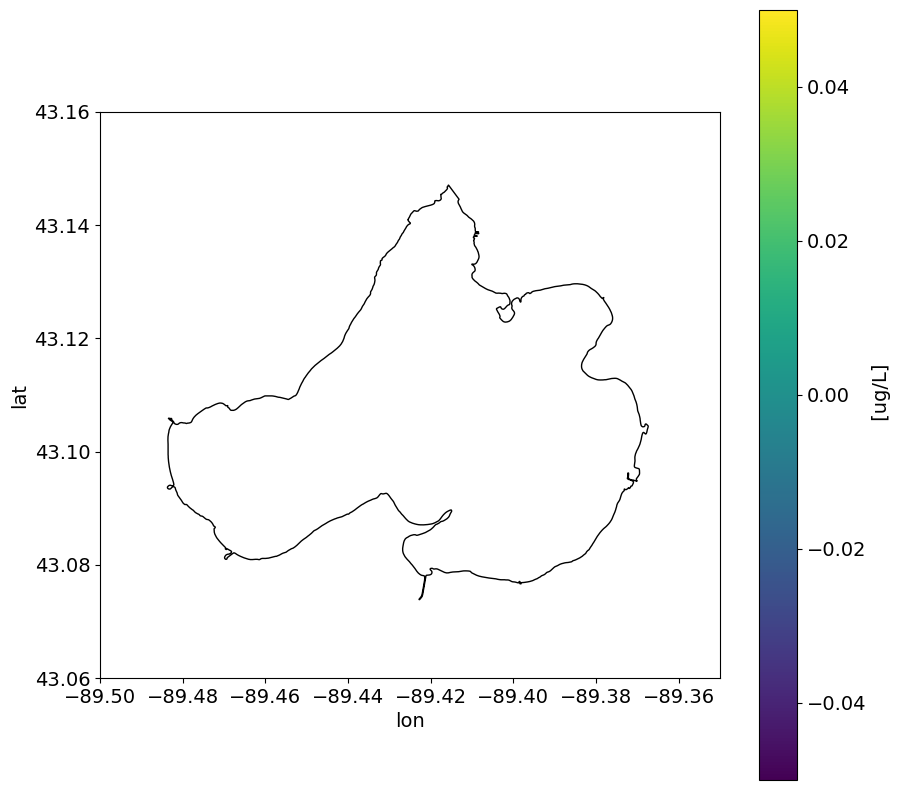

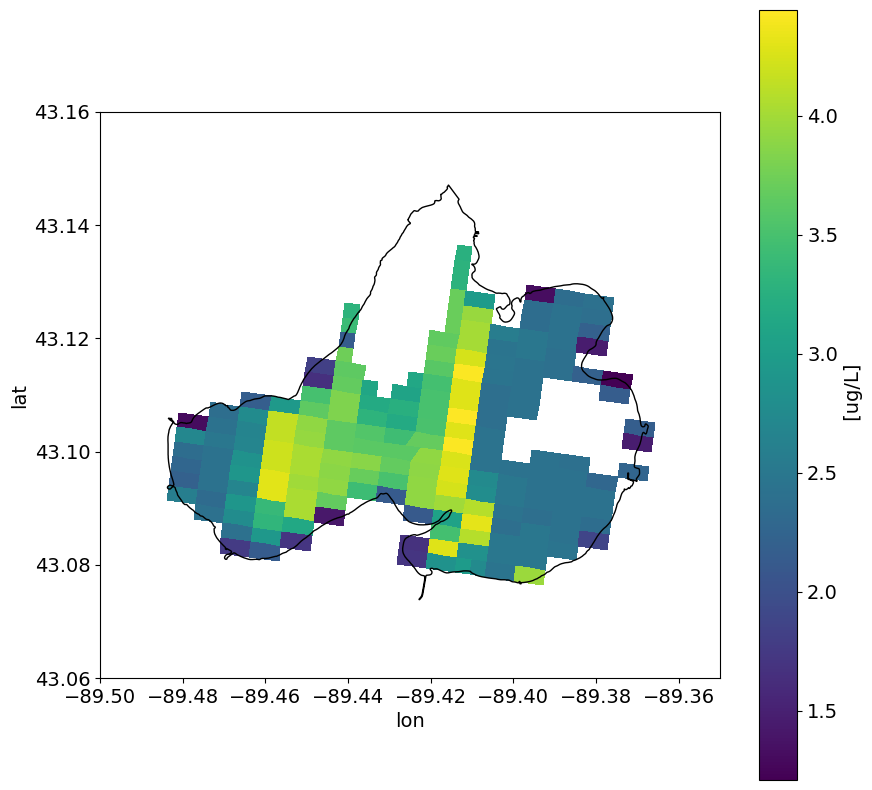

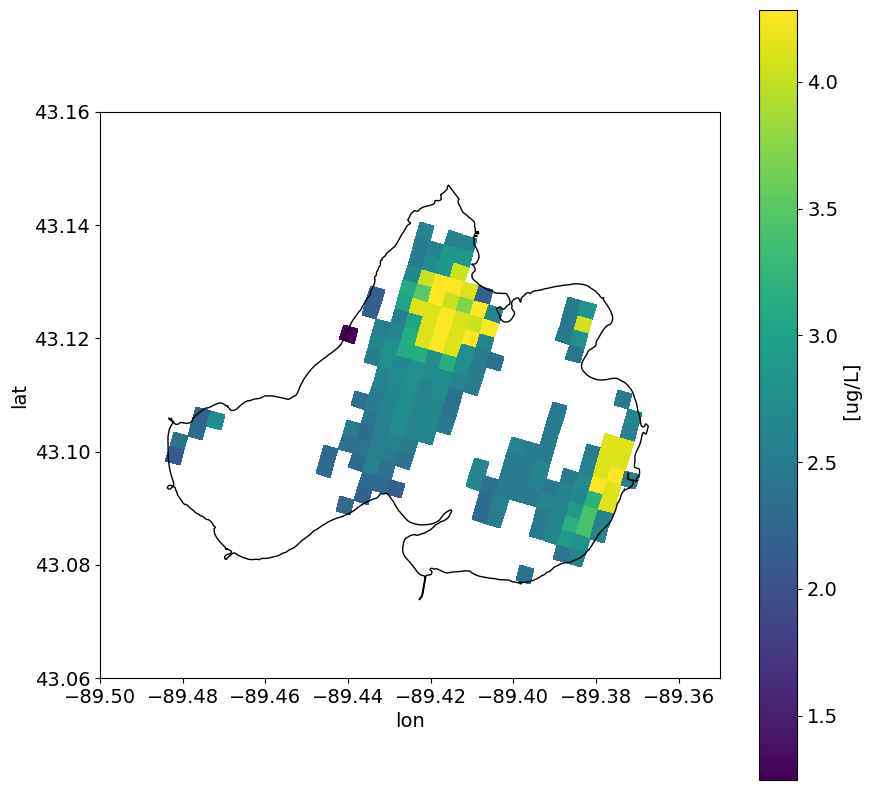

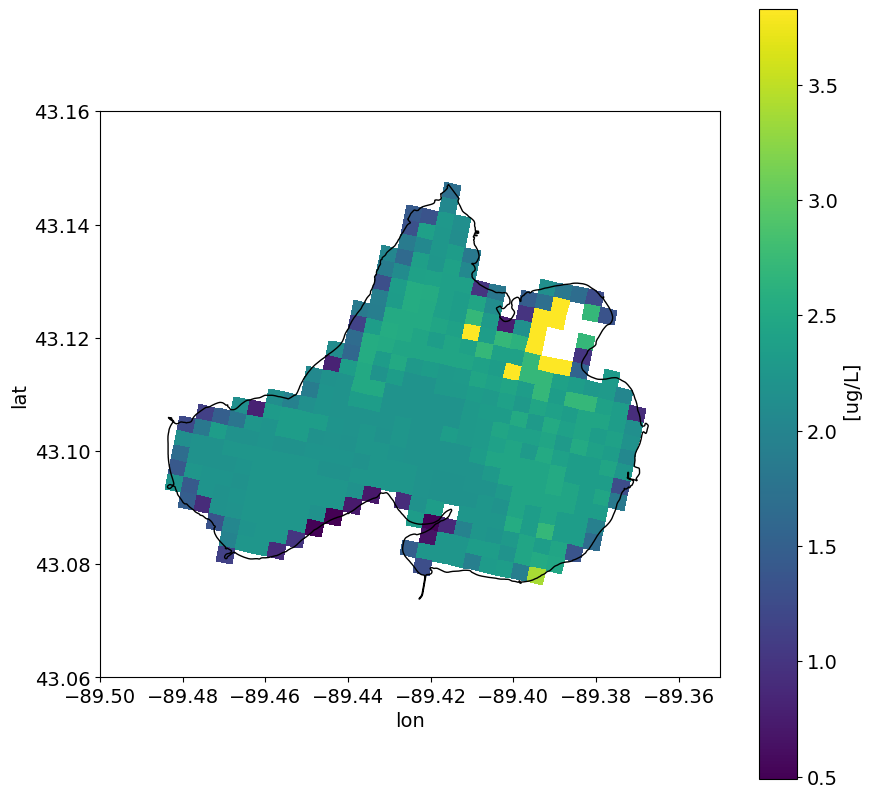

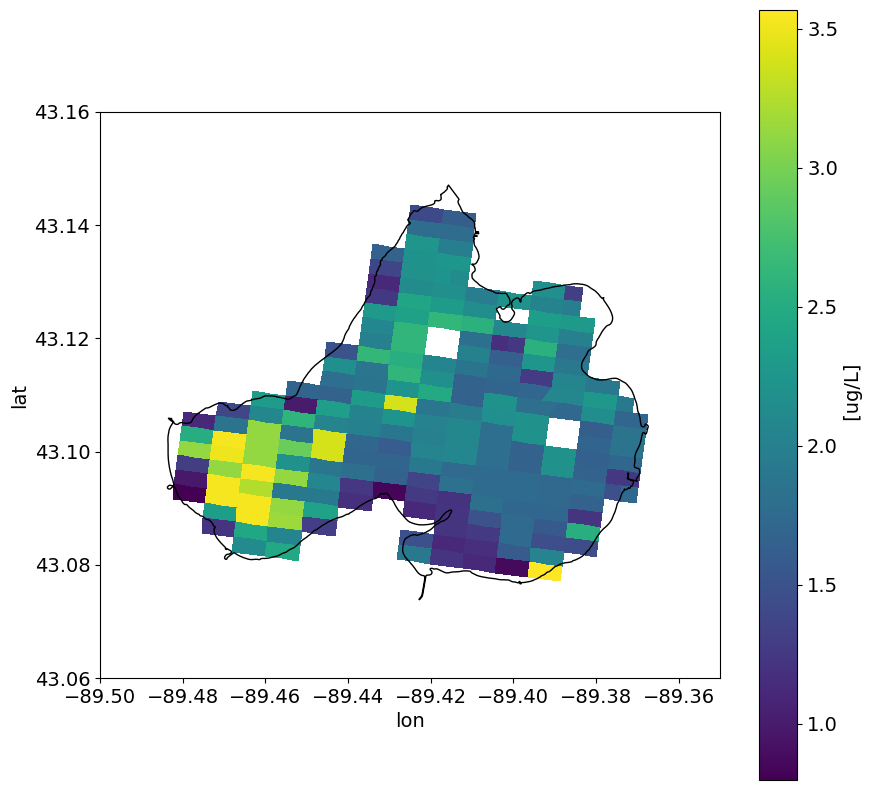

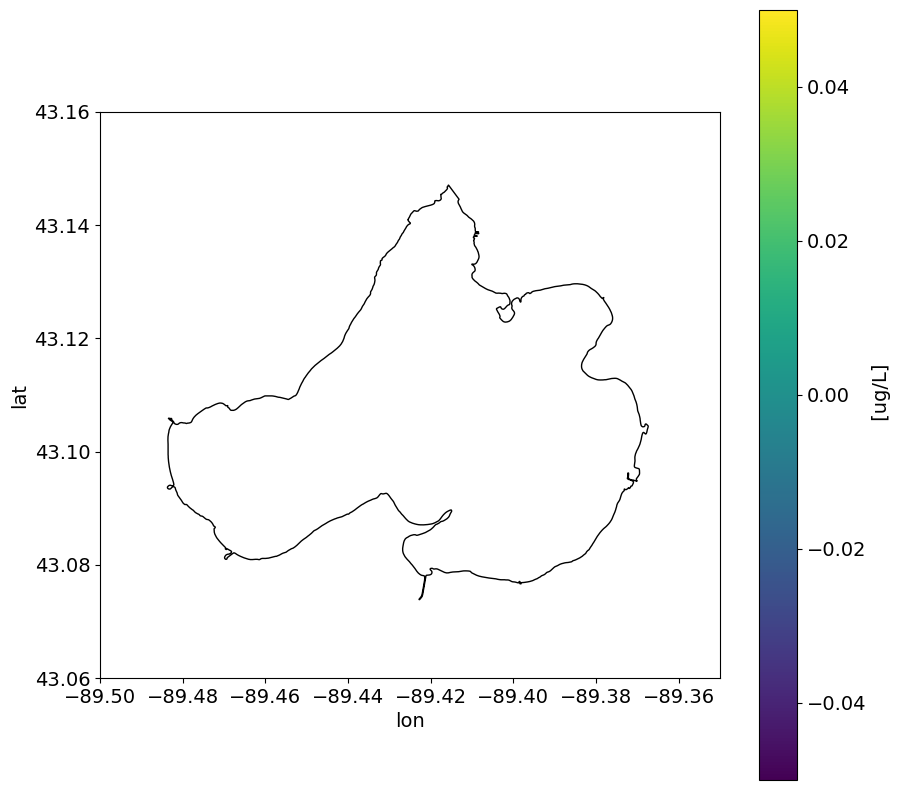

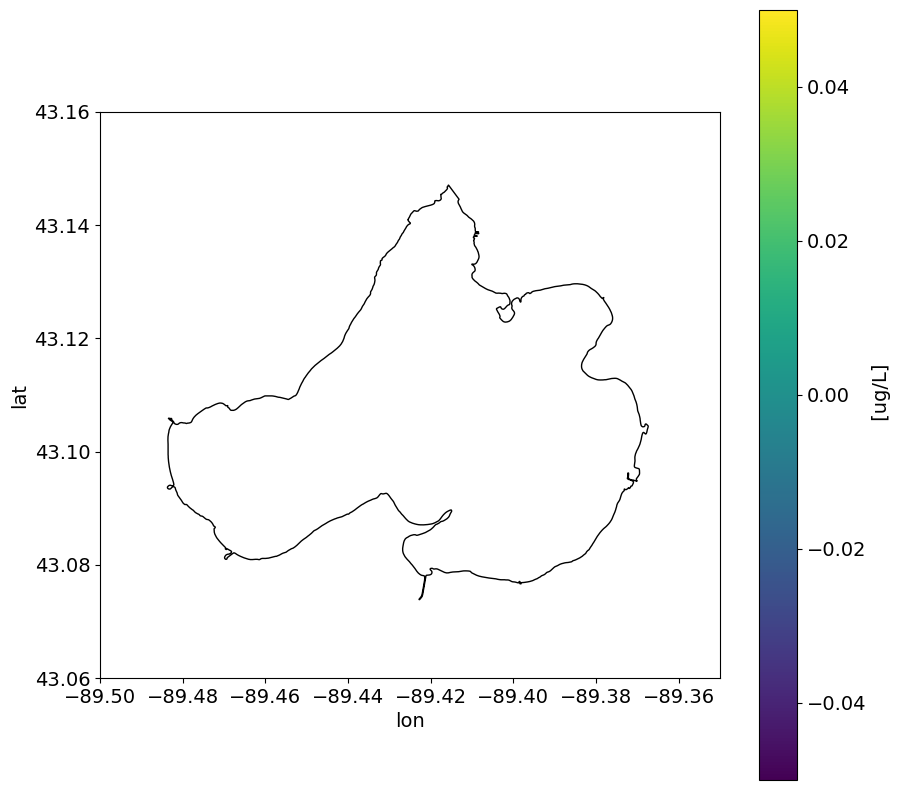

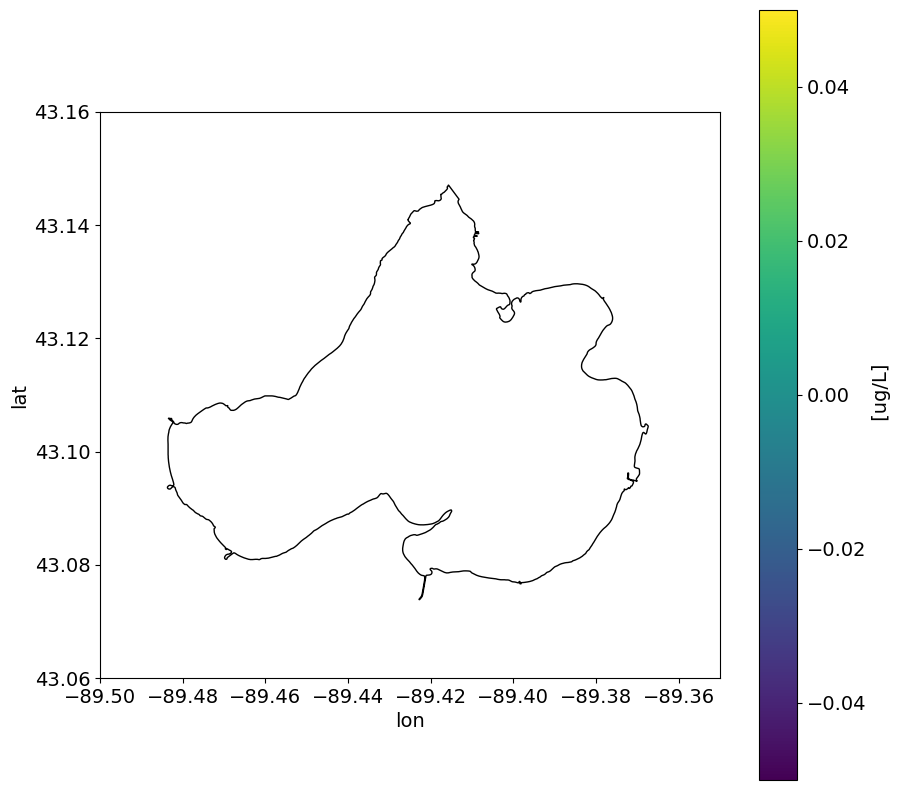

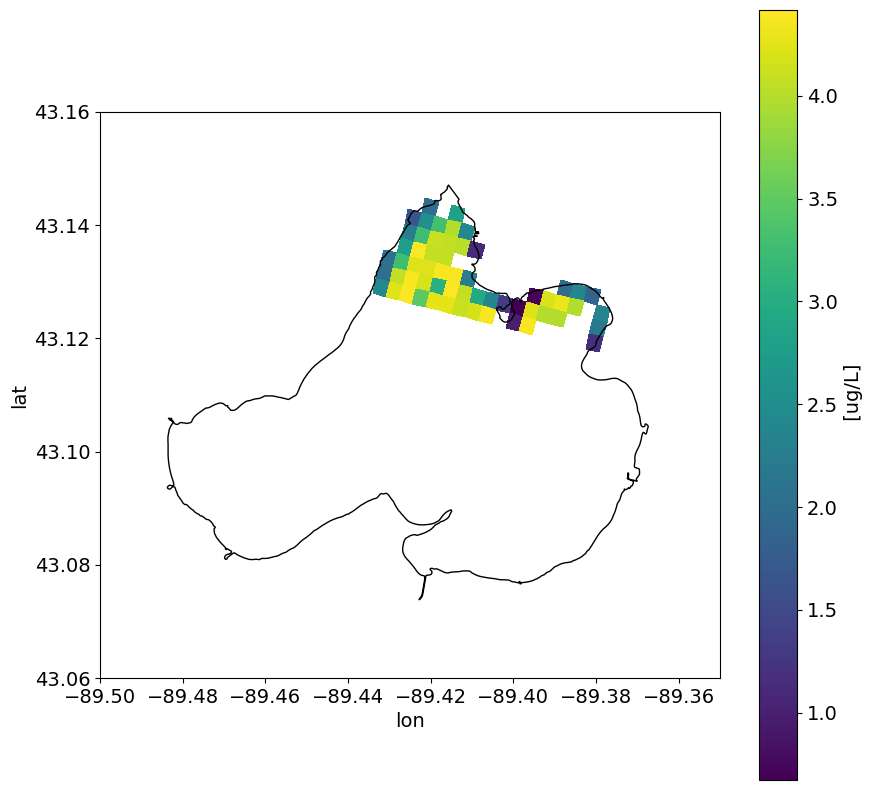

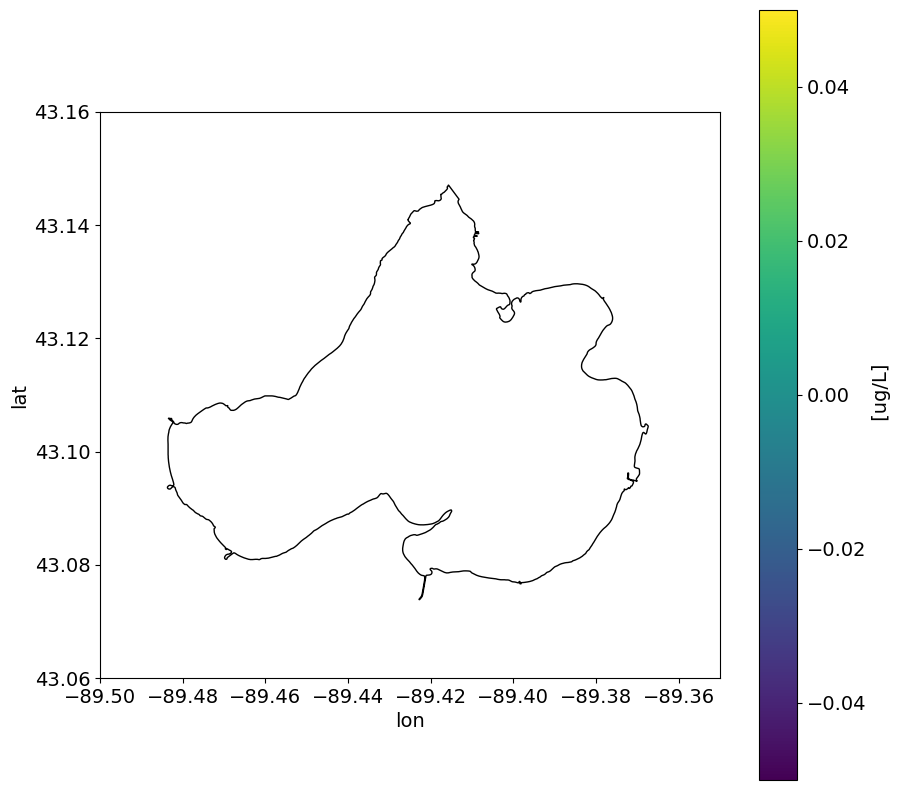

In [89]:
import warnings
import fiona
import numpy as np
from shapely.geometry import Polygon, Point, shape
from rasterio.plot import reshape_as_image
from scipy import stats as st
warnings.filterwarnings('ignore')

modelType = ['chl','pc','pcchl']
algae = ['Chlorophyll.µgL','BGA.PC.µgL','pc/chl']


for j, mtype in enumerate(modelType):
    hold = []
    pred_dates=[]
    
    best = bestPreds[j]
    
    modelStructure = chooseModel[chooseModel['metric']==algae[j]]['BestModel'].iloc[0]
    if modelStructure == "ANN":
        # load json and create model
        json_file = open(modelType[j]+"_ANN.json", 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        ann_model = model_from_json(loaded_model_json)
        # load weights into new model
        ann_model.load_weights(modelType[j]+"_ANN.h5")
        print("Loaded "+modelType[j]+" ANN model from disk")
        model=ann_model

    elif modelStructure == "RF":
        model = joblib.load(modelType[j]+"_rf.joblib")
        print("Loaded "+modelType[j]+" RF model from disk")

    
    for date, fn in enumerate(l2w):  
        #Open images
        dataset = xr.open_dataset(fn)
        dataset = dataset.assign_coords(lon = dataset.lon, lat = dataset.lat)
        names = list(dataset.keys())

        #Get features iteratively
        stack=[]
        for i in enumerate(list(dataset.data_vars)):
            stack.append(dataset[i[1]].to_numpy())

        stack = np.stack(stack, axis=0)
        stack = reshape_as_image(stack)


        #Reshape for prediction
        img_df=pd.DataFrame(stack.reshape(-1,stack.shape[2]))
        cols=list(dataset.data_vars)
        img_df.columns = cols


        #Band math 
        img_df["r709-620"]=img_df['rhow_709']-img_df['rhow_620']
        img_df["r709/620"]=img_df['rhow_709']/img_df['rhow_620']
        img_df['ndpci']=(img_df['rhow_709']-img_df['rhow_620'])/(img_df['rhow_709']+img_df['rhow_620'])


        #If every value in the dataset is an NA, skip to the next image
        if img_df.notna().sum().sum()==0:
            print('skipping')
            continue

        #If variables are missing from the predictor set, skip
        for var in best:
            if var in img_df.columns:
                missing=False
            else:
                print(var,'missing')
                missing = True
                break

        if missing == True:
            print('missing predictor, skipping')
            continue


        #Scale data
        scaler = StandardScaler()
        scaler.fit(img_df)
        Xsc=scaler.transform(img_df)
        Xsc = pd.DataFrame(Xsc)
        Xsc.columns = img_df.columns
        Xsc = Xsc.fillna(-999)

        #Drop
        #img_df=img_df.fillna(-999)
        #img_df.replace([np.inf, -np.inf], -999, inplace=True)



        ######Prediction########
        img=model.predict(Xsc[best])

        m,n = stack.shape[0],stack.shape[1]
        prediction = img.reshape(m,n)


        #Plot as xarray, reshape, crop to mendota extent
        lon = dataset['lon'].values
        lat = dataset['lat'].values


        da = xr.DataArray(
             data=prediction,
             dims=["y", "x"],
             coords=dict(
                 lon=(["y", "x"], lon),
                 lat=(["y", "x"], lat),
             ),
             attrs=dict(
                 description="",
                 units="ug/L",
             ),
         )



        if da.shape[0]==1:
            print('skipping')
            continue


        da=da.sortby(["y", "x"])
        da=da.rio.write_crs("epsg:4326")


        #Crop to mendota extent
        c = fiona.open("/Users/maxbeal/Desktop/PhD/Sampling/Mendota Shapefiles/Mendotaboundary4326.shp")
        pol = c.next()
        geom = shape(pol['geometry'])
        poly_data = pol["geometry"]["coordinates"][0]
        poly = Polygon(poly_data)
        xx = da['lon'].values
        yy = da['lat'].values
        xx=xx.reshape(-1,1)
        yy=yy.reshape(-1,1)
        points=np.concatenate((xx,yy),axis=1)
        mask = np.array([poly.contains(Point(x, y)) for x, y in points])
        mask_r=mask.reshape(m,n)
        da_mask=da.where(mask_r)


        #remove NaN
        if modelStructure=="ANN":
            da_mask=da_mask.where(da_mask.values>=0)
        elif modelStructure == "RF":       
            NAval=st.mode(da.values[~np.isnan(da.values)])
            da_mask=da_mask.where(da_mask.values!=NAval[0][0]) 



        ax = mendota.plot(figsize=(10,10), edgecolor="black", facecolor="None")
        da_mask.plot(x='lon', y='lat', ax=ax, zorder=-1)
        ax.set_xlim(-89.5,-89.35)
        ax.set_ylim(43.06,43.16)
        ax.set_title("")

        print(img_dates[date])
        hold.append(prediction)
        pred_dates.append(img_dates[date])

        if mtype == "chl":
            da_mask.to_netcdf('/Users/maxbeal/Desktop/PhD/Remote Sensing/pseudo_obs/s3_pseudo_obs/s3_chl_preds/'+img_dates[date]+'.nc',mode='w')
        elif mtype == "pc":
            da_mask.to_netcdf('/Users/maxbeal/Desktop/PhD/Remote Sensing/pseudo_obs/s3_pseudo_obs/s3_pc_preds/'+img_dates[date]+'.nc',mode='w')
        elif mtype == "pcchl":
            da_mask.to_netcdf('/Users/maxbeal/Desktop/PhD/Remote Sensing/pseudo_obs/s3_pseudo_obs/s3_pcchl_preds/'+img_dates[date]+'.nc',mode='w')






    
#result_arr = np.stack(result_arr, axis=0)



## Beach closings

Save beach shapes in 4326

In [5]:
#200m
jm = gpd.read_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/jm_200m_clip.shp')
jm = jm.to_crs("EPSG:4326")
jm.to_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/jm_200m_clip4326.shp', driver='ESRI Shapefile')

ten = gpd.read_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/ten_200m_clip.shp')
ten = ten.to_crs("EPSG:4326")
ten.to_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/ten_200m_clip4326.shp', driver='ESRI Shapefile')

war = gpd.read_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/war_200m_clip.shp')
war = war.to_crs("EPSG:4326")
war.to_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/war_200m_clip4326.shp', driver='ESRI Shapefile')


sh = gpd.read_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/sh_200m_clip.shp')
sh = sh.to_crs("EPSG:4326")
sh.to_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/sh_200m_clip4326.shp', driver='ESRI Shapefile')

mcp = gpd.read_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/mcp_200m_clip.shp')
mcp = mcp.to_crs("EPSG:4326")
mcp.to_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/mcp_200m_clip4326.shp', driver='ESRI Shapefile')


mem = gpd.read_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/mem_200m_clip.shp')
mem = mem.to_crs("EPSG:4326")
mem.to_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/mem_200m_clip4326.shp', driver='ESRI Shapefile')

mar = gpd.read_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/mar_200m_clip.shp')
mar = mar.to_crs("EPSG:4326")
mar.to_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/mar_200m_clip4326.shp', driver='ESRI Shapefile')



In [58]:
#!pip install rasterstats
import rasterio
from rasterio.plot import show
import os
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.mask import mask
from matplotlib import pyplot
import datetime
from itertools import compress
from rasterstats import zonal_stats


chl = 'Chlorophyll.µgL'
pc = 'BGA.PC.µgL'
pc_chl = 'pc/chl'

predictand = pc

#Beach shapefiles

#200m
jm = gpd.read_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/jm_200m_clip4326.shp')
ten = gpd.read_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/ten_200m_clip4326.shp')
war = gpd.read_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/war_200m_clip4326.shp')
sh = gpd.read_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/sh_200m_clip4326.shp')
mcp = gpd.read_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/mcp_200m_clip4326.shp')
mem = gpd.read_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/mem_200m_clip4326.shp')
mar = gpd.read_file('/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/mar_200m_clip4326.shp')

mendota2 = gpd.read_file("/Users/maxbeal/Desktop/PhD/Sampling/Mendota Shapefiles/Mendotaboundary.shp")


#Beach closing data
bc=pd.read_csv('/Users/maxbeal/Desktop/PhD/Remote Sensing/cyano_beachclosing.csv')
bc=bc[bc['lake']=='Mendota']


imgs = []
dates = []
datelist_tf= []
Dateset = list(bc['sampledate'])

onlyfiles=os.listdir(pred_path)

for name in onlyfiles:
        if name[-9:]=='.DS_Store':
            print('skip')
            next
        else:
            fp = os.path.join(pred_path, name)
            imgs = imgs + [fp]
            dates = dates + [name[0:10]]
            tf = name[0:10] in Dateset
            datelist_tf.append(tf)



Datelist=list(compress(dates, datelist_tf))


#Change to Xarray
#200m
#something wrong with the tenney shapefile
bchlist=['/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/jm_200m_clip4326.shp', 
         '/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/war_200m_clip4326.shp',
         '/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/sh_200m_clip4326.shp', 
         '/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/mcp_200m_clip4326.shp',
         '/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/mem_200m_clip4326.shp',
         '/Users/maxbeal/Desktop/PhD/Remote Sensing/RS_beaches/mar_200m_clip4326.shp']

bchname=["James Madison","Warner","Spring Harbor","Madison County Park","Memorial Union","Marshall"]

beachout = []
values = []
date = []

#Change to Xarray
for i, img in enumerate(imgs):
    pred = xr.open_dataarray(img)
    m,n = pred.values.shape
    print(img[-13:-3])
    for j, b in enumerate(bchlist):
        c = fiona.open(b)
        pol = next(iter(c))
        c.close()
        geom = shape(pol['geometry'])
        poly_data = pol["geometry"]["coordinates"][0]
        poly = Polygon(poly_data)
        xx = pred['lon'].values
        yy = pred['lat'].values
        xx=xx.reshape(-1,1)
        yy=yy.reshape(-1,1)
        points=np.concatenate((xx,yy),axis=1)
        mask = np.array([poly.contains(Point(x, y)) for x, y in points])
        mask_r=mask.reshape(m,n)
        pred_mask=pred.where(mask_r)
    
        beachout.append(bchname[j])
        values.append(np.nanmean(pred_mask.values))
        date.append(img[-13:-3])
    
    
    
        #ax = mendota.plot(figsize=(10,10), edgecolor="black", facecolor="None")
        #pred_mask.plot(x='lon', y='lat', ax=ax, zorder=-1)
        #ax.set_xlim(-89.5,-89.35)
        #ax.set_ylim(43.06,43.16)


        zs=pd.DataFrame(zip(date,beachout,values))



  


#Save beaches data to csv
zs.to_csv('/Users/maxbeal/Desktop/PhD/Remote Sensing/pseudo_obs/s3_pseudo_obs/pc_beaches_200m')



NameError: name 'pred_path' is not defined

In [57]:
import pandas as pd
from datetime import timedelta
import datetime

#Beach closing data
bc=pd.read_csv('/Users/maxbeal/Desktop/PhD/Remote Sensing/cyano_beachclosing.csv')
bc=bc[bc['lake']=='Mendota']

beach = pd.read_csv('/Users/maxbeal/Desktop/PhD/Remote Sensing/pseudo_obs/s3_pseudo_obs/pc_beaches_200m') #Zonal statistics in each beach region 
beach=beach.iloc[:,1:4]

beach.columns = ['Date','Beach','mean']
beach=beach[beach['Date']!='.DS_Store']
beach['month']=pd.DatetimeIndex(beach['Date']).month

#subset to beach monitoring season
beach=beach[(beach['month']>=6) & (beach['month']<=8)]



dates = []
datelist_tf= []
beachname = []
datename = []
mean = []

d = {}
for b in beach['Beach']: #Subset beach
    sub = bc[bc['Beach']==b] #This is a subset of the beach closure data
    Dateset = list(sub['sampledate'])
    datelist_tf= []
    beachname = []
    datename = []
    mean = []
    for i, date in enumerate(beach[beach['Beach']==b]['Date']): #Which satellite days (used for zonal beach stats) coincide with beach closures?
        date_extend = []
        numdays=6 #Choose number of days to extend range by (i.e., is there a closure within 3 days (5 day window), 4 days (7 day window) of satellite pass, etc.)
        for x in range (0, numdays):
            #date_extend.append((pd.to_datetime(date) + timedelta(days=x)).strftime("%Y-%m-%d"))
            date_extend.append((pd.to_datetime(date) - timedelta(days=x)).strftime("%Y-%m-%d")) #Before
            date_extend = list(np.unique(date_extend))

        datelist_tf.append(any(date in Dateset for date in date_extend))
        beachname.append(b)
        datename.append(date)
        mean.append(beach[beach['Beach']==b]['mean'].iloc[i])
    d[b+' closed'] = pd.DataFrame({'closed':datelist_tf,'Beach':beachname,'Date':datename,'mean':mean})

jm_close = pd.DataFrame(d['James Madison closed'])
mcp_close = pd.DataFrame(d['Madison County Park closed'])
mar_close = pd.DataFrame(d['Marshall closed'])
mem_close = pd.DataFrame(d['Memorial Union closed'])
sh_close = pd.DataFrame(d['Spring Harbor closed'])
war_close = pd.DataFrame(d['Warner closed'])

jm_close=jm_close.sort_values(by='Date')
mcp_close=mcp_close.sort_values(by='Date')
mar_close=mar_close.sort_values(by='Date')
mem_close=mem_close.sort_values(by='Date')
sh_close=sh_close.sort_values(by='Date')
war_close=war_close.sort_values(by='Date')

beach = pd.concat([jm_close,mcp_close,mar_close,mem_close,sh_close,war_close])


print(beach.groupby(['closed','Beach'])['mean'].mean())
print(beach.groupby(['closed','Beach'])['mean'].std())

st_err = beach.groupby(['closed','Beach'])['mean'].std().unstack()

print(beach.groupby('closed')['Beach'].count())

df = beach.groupby(['closed','Beach'])['mean'].mean().unstack()
df.plot.bar(figsize=(10,8), yerr = st_err).legend(loc=2, prop={'size': 9})
win = (numdays*2)-1
title = "Phycocyanin/Chlorophyll 200m buffer: {} days previous".format(numdays)
plt.title(title)
plt.show()

print(date)
print(date_extend)



FileNotFoundError: [Errno 2] No such file or directory: '/Users/maxbeal/Desktop/PhD/Remote Sensing/pseudo_obs/s3_pseudo_obs/pc_beaches_200m'

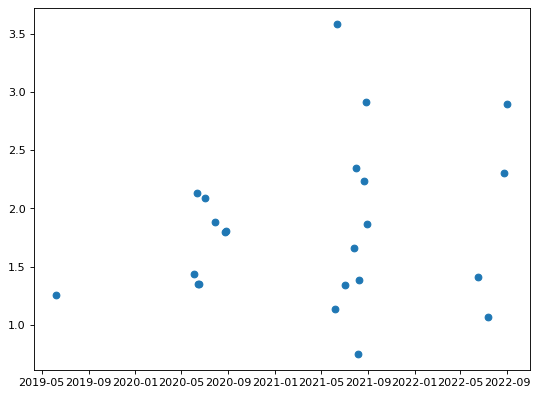

NameError: name 'da_mask' is not defined

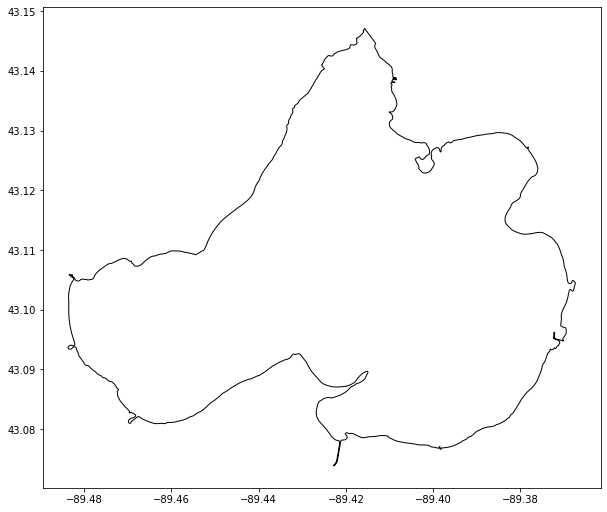

In [59]:
beach = pd.concat([jm_close,mcp_close,mar_close,mem_close,sh_close,war_close])


import datetime as dt

jm_close=jm_close.sort_values(by='Date')
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in jm_close['Date']]



figure(figsize=(8, 6), dpi=80)
plt.scatter(x,war_close['mean'])
plt.show()



ax = mendota.plot(figsize=(10,10), edgecolor="black", facecolor="None")
da_mask.plot(x='lon', y='lat', ax=ax, zorder=-1)
ax.set_xlim(-89.5,-89.35)
ax.set_ylim(43.06,43.16)